In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodel
from scipy import stats
import time

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'

In [4]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist( values.flatten().detach().cpu().numpy() )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [5]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [6]:
def print_stats_too_big(name:str, values:torch.Tensor):
    values, _ = torch.sort( values.flatten() )
    num_values = values.numel()
    min_val = values[0]
    low_end = (num_values * 25)//1000
    low_val = values[low_end]
    print(f'lower quantile {low_end}, -1 and +1', values[low_end-1], values[low_end], values[low_end+1] )
    half_index = num_values//2
    print(f'half way point {half_index}, -1 and +1', values[half_index-1], values[half_index], values[half_index+1] )
    if (num_values % 2) == 0:
        med_val = (values[half_index] + values[half_index+1])/2
    else:
        med_val = values[half_index+1]
    high_end = (num_values * 975)//1000
    high_val = values[high_end]
    print(f'upper quantile {high_end}, -1 and +1', values[high_end-1], values[high_end], values[high_end+1] )
    max_val = values[-1]
    print(f'The distribution of {name} values has median {med_val:.3g} with 95% CI [{low_val:.3g}, {high_val:.3g}] and range [{min_val:.3g}, {max_val:.3g}].')

In [7]:
def make_scatter(xname:str, xvalues:torch.Tensor, yname:str, yvalues:torch.Tensor, save:bool=False, file_name:str=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.scatter( xvalues.flatten().detach().cpu().numpy(), yvalues.flatten().detach().cpu().numpy() )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xname)
    axs.set_ylabel(yname)
    # axs.set_title(f'{xname} vs {yname}')
    plt.show()
    if save:
        plt.savefig(file_name)

In [8]:
def bin_feature_mean_param_var(feature:torch.Tensor, param:torch.Tensor, bin_size:int):
    if len( param.size() ) > 2:
        models_per_subject = param.size(dim=0)
        feature = feature.unsqueeze(dim=0).repeat( (models_per_subject, 1, 1) )
    feature = feature.flatten()
    param = param.flatten()
    feature_sorted, sort_indices = torch.sort(feature, descending=False)
    param_sorted = param[sort_indices]
    total_num_values = feature_sorted.numel()
    num_bins = total_num_values//bin_size
    num_values_in_bins = num_bins*bin_size
    feature_means = feature_sorted[:num_values_in_bins].unflatten( dim=0, sizes=(num_bins, bin_size) ).mean(dim=-1)
    param_vars = param_sorted[:num_values_in_bins].unflatten( dim=0, sizes=(num_bins, bin_size) ).var(dim=-1)
    return feature_means, param_vars

In [9]:
def bin_frequency_mean_h_quantile(frequency:torch.Tensor, h:torch.Tensor, bin_size:int, q:float):
    frequency = frequency.flatten()
    h = h.flatten()
    frequency_sorted, sort_indices = torch.sort(frequency, descending=False)
    h_sorted = h[sort_indices]
    total_num_values = frequency_sorted.numel()
    num_bins = total_num_values//bin_size
    num_values_in_bins = num_bins*bin_size
    frequency_means = frequency_sorted[:num_values_in_bins].unflatten( dim=0, sizes=(num_bins, bin_size) ).mean(dim=-1)
    h_quantile = torch.quantile(  h_sorted[:num_values_in_bins].unflatten( dim=0, sizes=(num_bins, bin_size) ), q=q, dim=-1  )
    return frequency_means, h_quantile

In [10]:
def print_proportions_of_variance_explained(variable_name:str, explainer_name:str, values:torch.Tensor, dim):
    mean_of_variance = torch.mean( torch.var(values, dim=dim) )
    variance_of_mean = torch.var( torch.mean(values, dim=dim) )
    total_variance = torch.var(values)
    proportion_unexplained = mean_of_variance/total_variance
    proportion_explained = variance_of_mean/total_variance
    F_stat = variance_of_mean/mean_of_variance
    proportion_sum = proportion_explained + proportion_unexplained
    print(f'proportion of variance of {variable_name} explained by {explainer_name} = {variance_of_mean:.3g}/{total_variance:.3g} = {proportion_explained:.3g}. Proportion unexplained = {mean_of_variance:.3g}/{total_variance:.3g} = {proportion_unexplained:.3g}. F-stat = {F_stat:.3g}. Explained + unexplained = {proportion_sum:.3g}.')

In [11]:
def make_histogram_pair(values1:torch.Tensor, values2:torch.Tensor, label1:str, label2:str, xlabel:str):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    values1_flat = values1.flatten().detach().cpu().numpy()
    values2_flat = values2.flatten().detach().cpu().numpy()
    axs.hist( values1_flat, label=label1 )
    axs.hist( values2_flat, label=label2 )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(xlabel)
    axs.set_ylabel('count in bin')
    # axs.set_title(f'distribution of {xlabel}')
    axs.legend()
    plt.show()
    print( stats.mannwhitneyu(x=values1_flat, y=values2_flat) )

In [221]:
data_fc_intra_subject_ranges = torch.load( os.path.join(file_dir, 'data_fc_intra_subject_ranges.pt') )
print( data_fc_intra_subject_ranges.size() )

torch.Size([837, 64620])


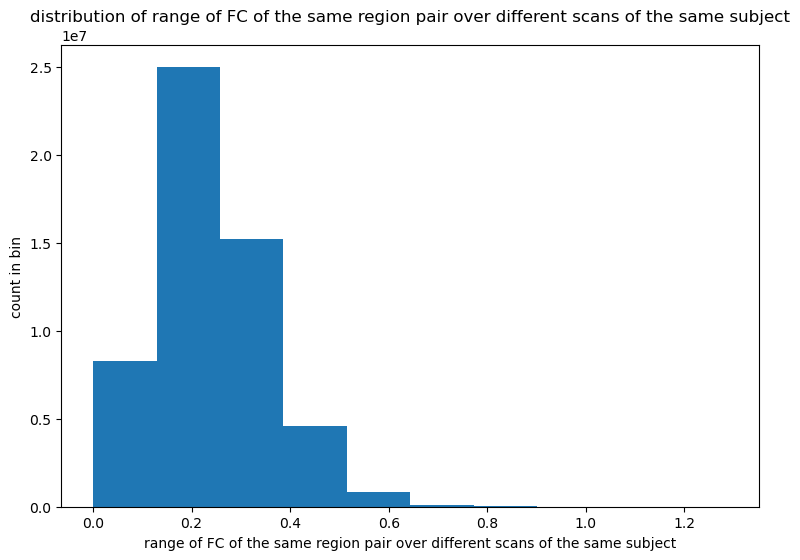

lower quantile 1352173, -1 and +1 tensor(0.0667, device='cuda:0') tensor(0.0667, device='cuda:0') tensor(0.0667, device='cuda:0')
half way point 27043470, -1 and +1 tensor(0.2267, device='cuda:0') tensor(0.2267, device='cuda:0') tensor(0.2267, device='cuda:0')
upper quantile 52734766, -1 and +1 tensor(0.4933, device='cuda:0') tensor(0.4933, device='cuda:0') tensor(0.4933, device='cuda:0')
The distribution of range of FC of the same region pair over different scans of the same subject values has median 0 with 95% CI [0.0667, 0.493] and range [0, 1.29].


In [222]:
name = 'range of FC of the same region pair over different scans of the same subject'
values = data_fc_intra_subject_ranges
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

In [14]:
data_fc_intra_subject_var = torch.load( os.path.join(file_dir, 'data_fc_intra_subject_variances.pt') )[0:669,:]
print( data_fc_intra_subject_var.size() )

torch.Size([669, 64620])


In [15]:
name = 'variance of FC of the same region pair over different scans of the same subject'
values = data_fc_intra_subject_var
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

lower quantile 1080769, -1 and +1 tensor(0.0009, device='cuda:0') tensor(0.0009, device='cuda:0') tensor(0.0009, device='cuda:0')
half way point 21615390, -1 and +1 tensor(0.0101, device='cuda:0') tensor(0.0101, device='cuda:0') tensor(0.0101, device='cuda:0')
upper quantile 42150010, -1 and +1 tensor(0.0476, device='cuda:0') tensor(0.0476, device='cuda:0') tensor(0.0476, device='cuda:0')
The distribution of variance of FC of the same region pair over different scans of the same subject values has median 0 with 95% CI [0.000863, 0.0476] and range [0, 0.337].


In [223]:
data_fc_intra_subject_std = data_fc_intra_subject_var.sqrt()
print( data_fc_intra_subject_std.size() )

torch.Size([837, 64620])


In [224]:
name = 'standard deviation of FC of the same region pair over different scans of the same subject'
values = data_fc_intra_subject_std
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

lower quantile 1352173, -1 and +1 tensor(0.0295, device='cuda:0') tensor(0.0295, device='cuda:0') tensor(0.0295, device='cuda:0')
half way point 27043470, -1 and +1 tensor(0.1010, device='cuda:0') tensor(0.1010, device='cuda:0') tensor(0.1010, device='cuda:0')
upper quantile 52734766, -1 and +1 tensor(0.2195, device='cuda:0') tensor(0.2195, device='cuda:0') tensor(0.2195, device='cuda:0')
The distribution of standard deviation of FC of the same region pair over different scans of the same subject values has median 0 with 95% CI [0.0295, 0.219] and range [0, 0.58].


In [18]:
# Since these are the target FCs, they are the same for each instance of model for the same subject.
FC_file = os.path.join(file_dir, 'target_state_product_means_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
FC = torch.load(FC_file)[0,:,:]
print( FC.size() )

torch.Size([669, 64620])


In [19]:
name = 'combined FC of individual region pair taken over all scans of the same subject'
values = FC
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

lower quantile 1080769, -1 and +1 tensor(-0.0258, device='cuda:0') tensor(-0.0258, device='cuda:0') tensor(-0.0258, device='cuda:0')
half way point 21615390, -1 and +1 tensor(0.2433, device='cuda:0') tensor(0.2433, device='cuda:0') tensor(0.2433, device='cuda:0')
upper quantile 42150010, -1 and +1 tensor(0.5583, device='cuda:0') tensor(0.5583, device='cuda:0') tensor(0.5583, device='cuda:0')
The distribution of combined FC of individual region pair taken over all scans of the same subject values has median 0 with 95% CI [-0.0258, 0.558] and range [-0.422, 0.923].


In [54]:
beta_file = os.path.join(file_dir, 'beta_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01.pt')

In [9]:
model = torch.load( os.path.join(file_dir, 'ising_model_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01.pt') )
print( model.beta.size() )
torch.save(model.beta, beta_file)

torch.Size([4190, 1])


In [41]:
beta = torch.load(beta_file)
print( beta.size() )
beta = beta.squeeze().unflatten( dim=0, sizes=(5,-1) )[:,1:670]
print( 'training subject beta values size', beta.size() )
print( beta[:,0] )
beta_first = beta[0,:]

torch.Size([4190, 1])
training subject beta values size torch.Size([5, 669])
tensor([0.0145, 0.0145, 0.0145, 0.0145, 0.0145], device='cuda:0')


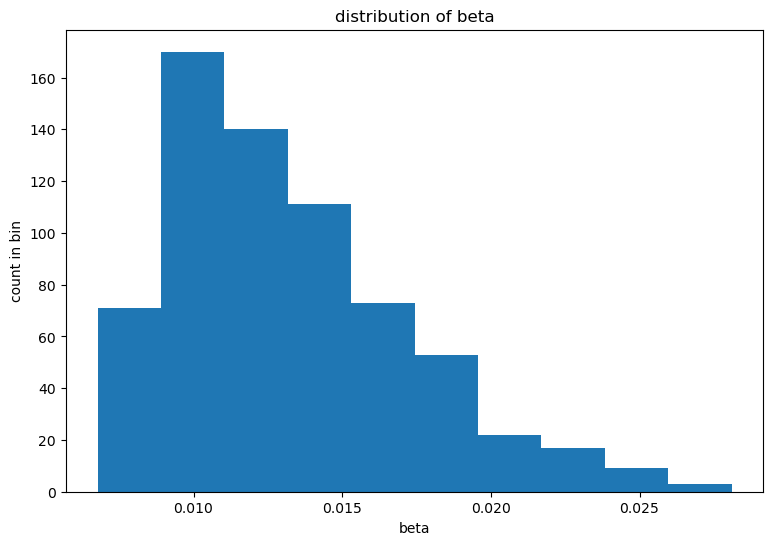

The distribution of beta values has median 0.0124 with 95% CI [0.00795, 0.0228] and range [0.00677, 0.0281].


In [42]:
name = 'beta'
values = beta_first
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [19]:
beta_j_1200_file = os.path.join(file_dir, 'beta_for_j_group_training_and_individual_all_reps_5_steps_1200_beta_updates_39.pt')
beta_j_1200 = torch.load(beta_j_1200_file)
print( beta_j_1200.size() )
print( beta_j_1200.flatten().tolist() )

torch.Size([5, 1, 1, 1])
[0.01219710148870945, 0.01219710148870945, 0.01219710148870945, 0.01219710148870945, 0.01219710148870945]


In [20]:
beta_j_12000_file = os.path.join(file_dir, 'beta_for_j_group_training_and_individual_all_reps_12_steps_12000_beta_updates_17.pt')
beta_j_12000 = torch.load(beta_j_1200_file)
print( beta_j_12000.size() )
print( beta_j_12000.flatten().tolist() )

torch.Size([5, 1, 1, 1])
[0.01219710148870945, 0.01219710148870945, 0.01219710148870945, 0.01219710148870945, 0.01219710148870945]


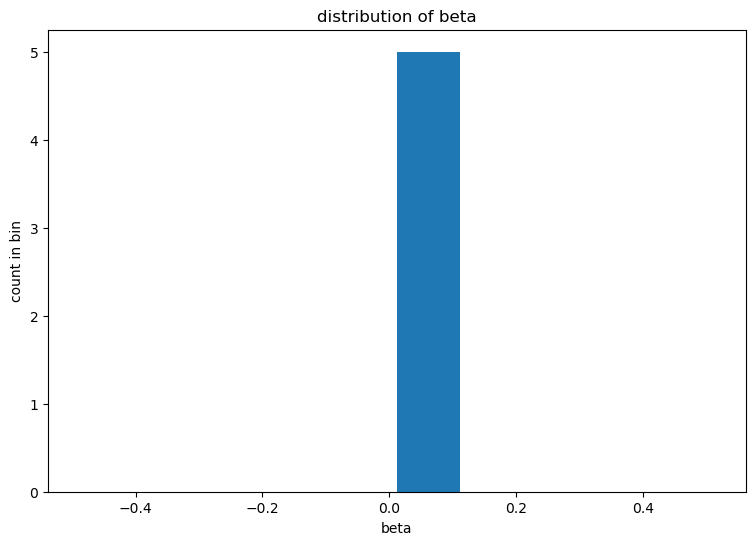

In [14]:
name = 'beta'
values = beta_j_1200
make_histogram(name=name, values=values)

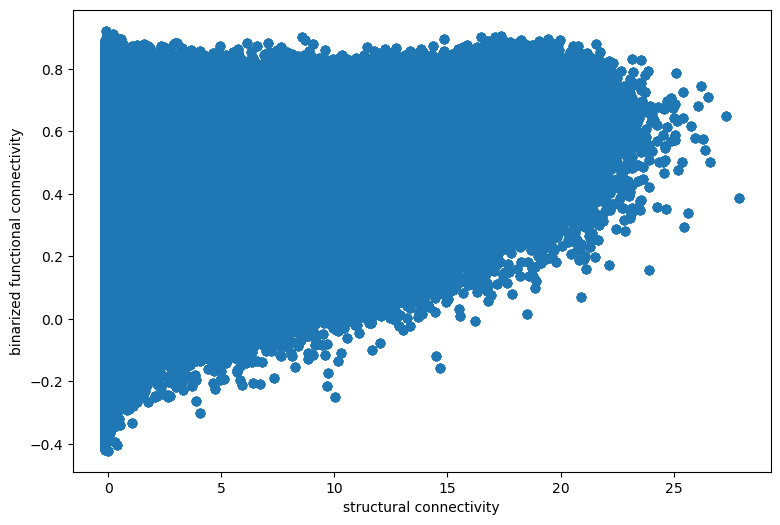

In [10]:
# make_scatter(xname='structural connectivity', xvalues=sc_j_mean_product_triples[:,:,:,0], yname='binarized functional connectivity', yvalues=sc_j_mean_product_triples[:,:,:,2])

In [11]:
# sc_j_mean_product_triples = torch.load( os.path.join(file_dir, 'edge_feature_0_J_mean_triples_group_training_and_individual_all.pt') )

In [12]:
# make_scatter(xname='structural connectivity', xvalues=sc_j_mean_product_triples[:,:,:,0], yname='Ising model coupling parameter', yvalues=sc_j_mean_product_triples[:,:,:,1])

In [19]:
node_features_file = os.path.join(file_dir, 'node_features_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
node_features = torch.load(node_features_file)
print( node_features.size() )

torch.Size([669, 360, 11])


In [86]:
h_file = os.path.join(file_dir, 'h_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
h = torch.load(h_file)
print( h.size() )

torch.Size([5, 669, 360])


In [11]:
name = 'h'
values = h
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

The distribution of h values has median -6.21e-07 with 95% CI [-0.000729, 0.000713] and range [-0.0022, 0.00236].


In [198]:
node_feature_names = ['radius', 'inclination', 'azimuth'] + ['x', 'y', 'z'] + ['thickness', 'myelination', 'curvature', 'sulcus depth'] + ['mean SC']

In [20]:
feature_index = 10
models_per_subject = h.size(dim=0)
make_scatter(  xname=node_feature_names[feature_index], xvalues=node_features[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='h', yvalues=h)

In [32]:
node_feature_means = torch.mean( node_features, dim=0 )
print( node_feature_means.size() )
h_variance = torch.var( h.flatten(start_dim=0, end_dim=1), dim=0 )
print( h_variance.size() )

torch.Size([360, 11])
torch.Size([360])


In [10]:
node_feature_means_names = [f'mean {name}' for name in node_feature_names]

NameError: name 'node_feature_names' is not defined

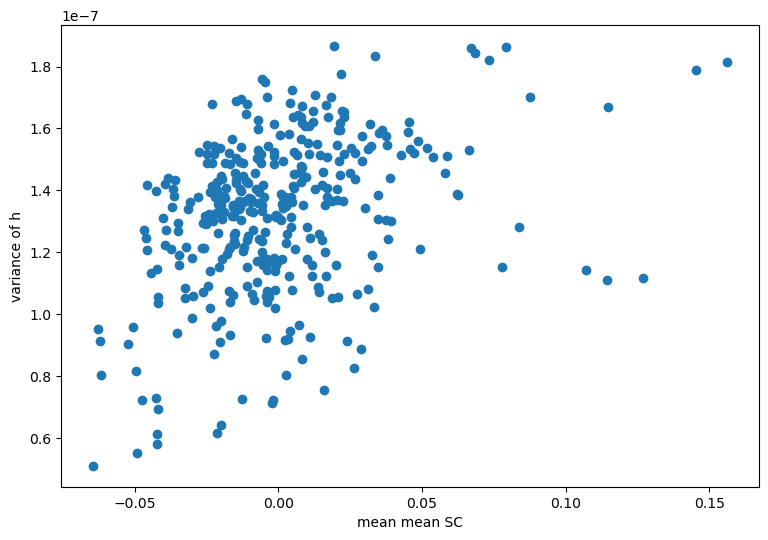

In [43]:
feature_index = 10
make_scatter(  xname=node_feature_means_names[feature_index], xvalues=node_feature_means[:,feature_index], yname='variance of h', yvalues=h_variance)

In [8]:
edge_features_file = os.path.join(file_dir, 'edge_features_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
edge_features = torch.load(edge_features_file)
print( edge_features.size() )

torch.Size([669, 64620, 13])


In [36]:
J_file = os.path.join(file_dir, 'J_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
J = torch.load(J_file)
print( J.size() )

torch.Size([5, 669, 64620])


In [10]:
name = 'J'
values = J
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

RuntimeError: quantile() input tensor is too large

In [12]:
print(f'J has median {torch.median(J):.3g} and range [{torch.min(J):.3g}, {torch.max(J):.3g}].')

J has median 0.00184 and range [-0.21, 0.52]


In [10]:
J_sorted, _ = torch.sort( J.flatten() )
num_J = J_sorted.numel()
print(num_J)
low_end = (num_J * 25)//1000
print(low_end, J_sorted[low_end])
high_end = (num_J * 975)//1000
print(high_end, J_sorted[high_end])
low_end_and_adjacent = [low_end-1, low_end, low_end+1]
print(low_end_and_adjacent, J_sorted[low_end_and_adjacent])
high_end_and_adjacent = [high_end-1, high_end, high_end+1]
print(high_end_and_adjacent, J_sorted[high_end_and_adjacent])

216153900
5403847 tensor(-0.0467, device='cuda:0')
210750052 tensor(0.0737, device='cuda:0')
[5403846, 5403847, 5403848] tensor([-0.0467, -0.0467, -0.0467], device='cuda:0')
[210750051, 210750052, 210750053] tensor([0.0737, 0.0737, 0.0737], device='cuda:0')


In [200]:
edge_feature_names = ['SC'] + ['distance'] + [f'|{pname} difference|' for pname in node_feature_names]

In [11]:
feature_index = 12
models_per_subject = J.size(dim=0)
make_scatter(  xname=edge_feature_names[feature_index], xvalues=edge_features[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='J', yvalues=J)

In [201]:
node_feature_names_for_files = ['radius', 'inclination', 'azimuth'] + ['x', 'y', 'z'] + ['thickness', 'myelination', 'curvature', 'sulcus_depth'] + ['mean_sc']
edge_feature_names_for_files = ['sc'] + ['distance'] + [f'{pname}_difference' for pname in node_feature_names_for_files]

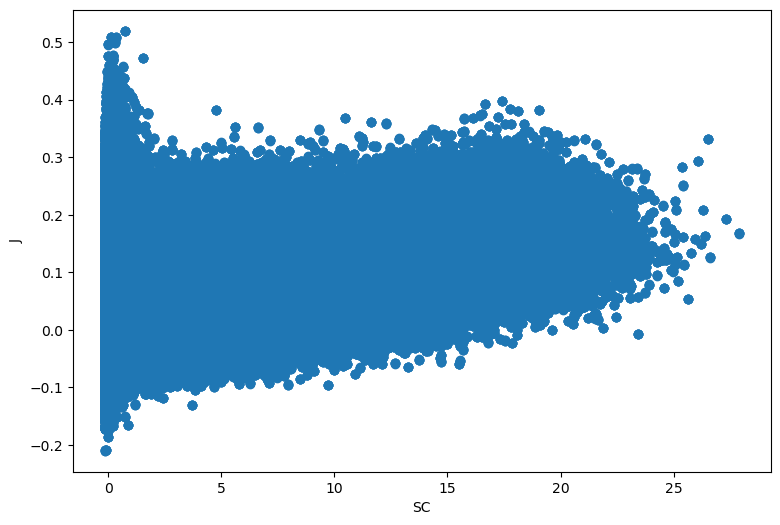

<Figure size 640x480 with 0 Axes>

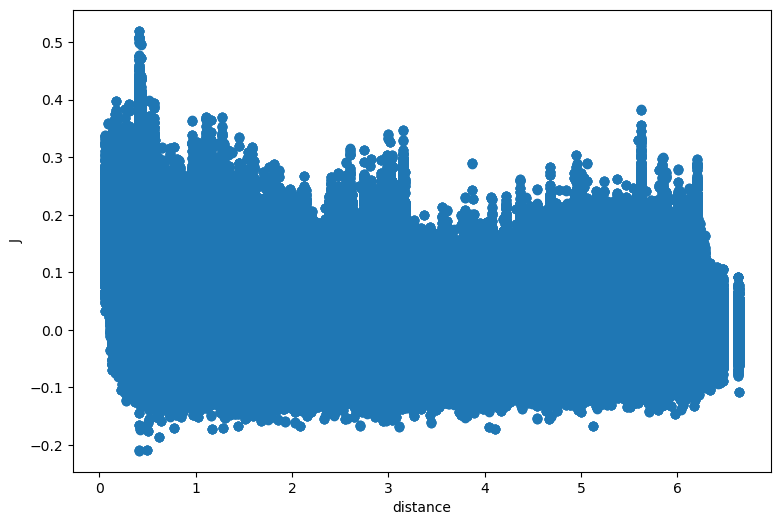

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

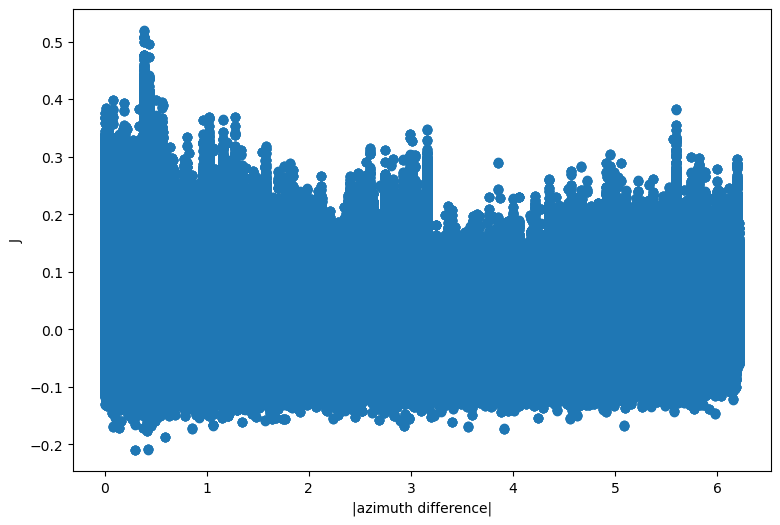

<Figure size 640x480 with 0 Axes>

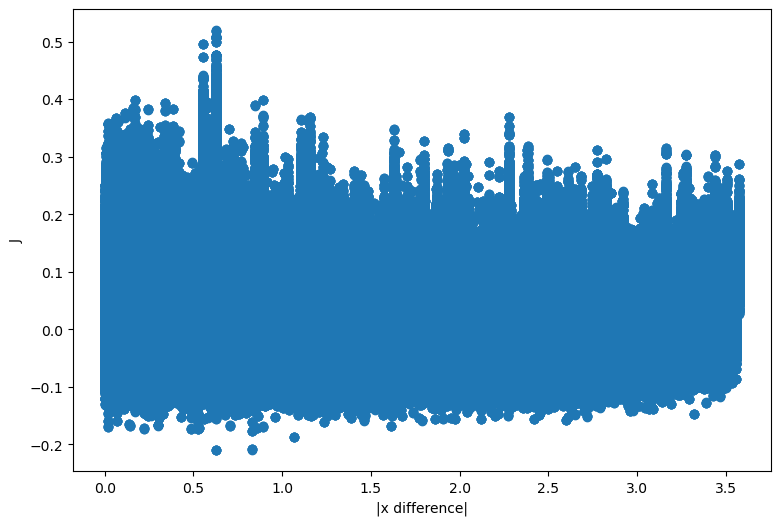

<Figure size 640x480 with 0 Axes>

In [ ]:
models_per_subject = J.size(dim=0)
for feature_index in range( len(edge_feature_names) ):
    file_name = os.path.join(file_dir, f'J_vs_{edge_feature_names_for_files[feature_index]}_training_data.png')
    make_scatter(  xname=edge_feature_names[feature_index], xvalues=edge_features[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='J', yvalues=J, save=True, file_name=file_name  )

In [13]:
edge_feature_means = torch.mean( edge_features, dim=0 )
print( edge_feature_means.size() )
J_variance = torch.var( J.flatten(start_dim=0, end_dim=1), dim=0 )
print( J_variance.size() )

torch.Size([64620, 13])
torch.Size([64620])


In [14]:
edge_feature_means_names = [f'mean {name}' for name in edge_feature_names]

In [29]:
feature_index = 12
models_per_subject = J.size(dim=0)
make_scatter(  xname=edge_feature_means_names[feature_index], xvalues=edge_feature_means[:,feature_index], yname='variance of J', yvalues=J_variance)

In [44]:
# Since these are the target FCs, they are the same for each instance of model for the same subject.
FC_file = os.path.join(file_dir, 'target_state_product_means_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
FC = torch.load(FC_file)[0,:,:]
print( FC.size() )

torch.Size([669, 64620])


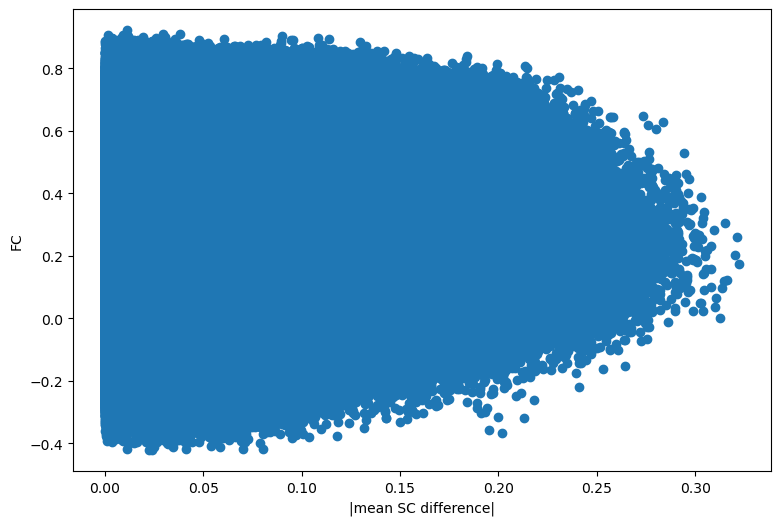

In [57]:
feature_index = 12
make_scatter(  xname=edge_feature_names[feature_index], xvalues=edge_features[:,:,feature_index], yname='FC', yvalues=FC)

In [19]:
node_variance_file = os.path.join(file_dir, 'node_variance_group_training_and_individual_all.pt')
node_variance = torch.load(node_variance_file)
print( node_variance.size() )

torch.Size([5, 669, 360])


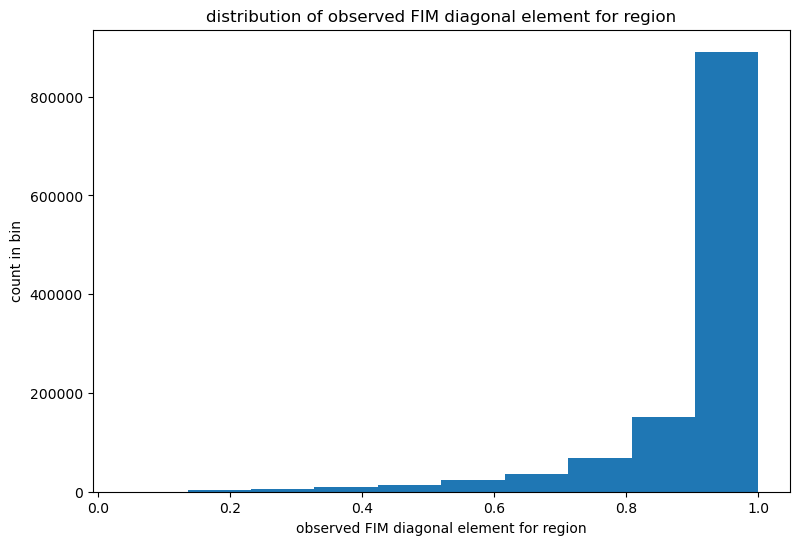

The distribution of observed FIM diagonal element for region values has median 0.971 with 95% CI [0.503, 1] and range [0.0396, 1].


In [13]:
name = 'observed FIM diagonal element for region'
values = node_variance
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [20]:
print_proportions_of_variance_explained( variable_name='node FIM diagonal element', explainer_name='node identity', values=node_variance, dim=(0,1) )

proportion of variance of node FIM diagonal element explained by node identity = 0.000466/0.0172 = 0.0271. Proportion unexplained = 0.0167/0.0172 = 0.973. F-stat = 0.0279. Explained + unexplained = 1.


In [21]:
print_proportions_of_variance_explained( variable_name='node FIM diagonal element', explainer_name='node and participant identity', values=node_variance, dim=0 )

proportion of variance of node FIM diagonal element explained by node and participant identity = 0.0066/0.0172 = 0.385. Proportion unexplained = 0.0132/0.0172 = 0.769. F-stat = 0.5. Explained + unexplained = 1.15.


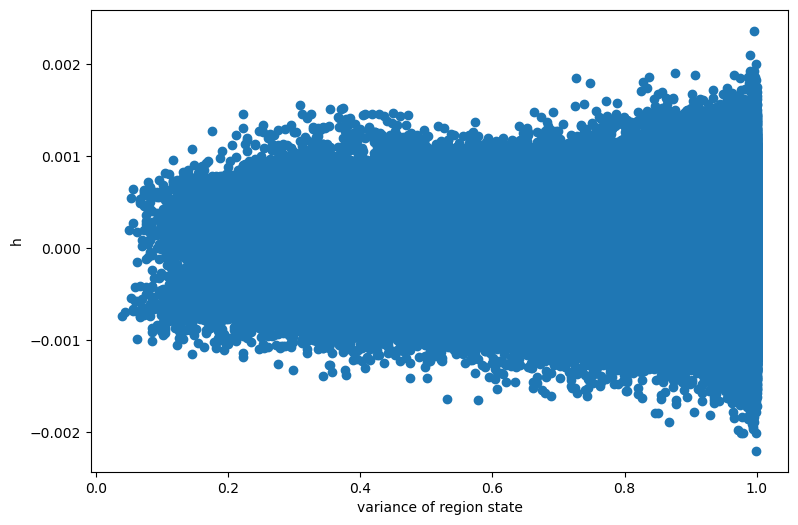

In [226]:
make_scatter(  xname='variance of region state', xvalues=node_variance, yname='h', yvalues=h)

In [228]:
node_features_repped = node_features.unsqueeze(dim=0).repeat( (models_per_subject,1,1,1) )

NameError: name 'node_features' is not defined

In [229]:
feature_index = 0
models_per_subject = node_variance.size(dim=0)
make_scatter(  xname=node_feature_names[feature_index], xvalues=node_features_repped[:,:,:,feature_index], yname='variance of region state', yvalues=node_variance)

NameError: name 'node_feature_names' is not defined

In [12]:
edge_variance_file = os.path.join(file_dir, 'edge_variance_group_training_and_individual_all.pt')
edge_variance = torch.load(edge_variance_file)
print( edge_variance.size() )

torch.Size([5, 669, 64620])


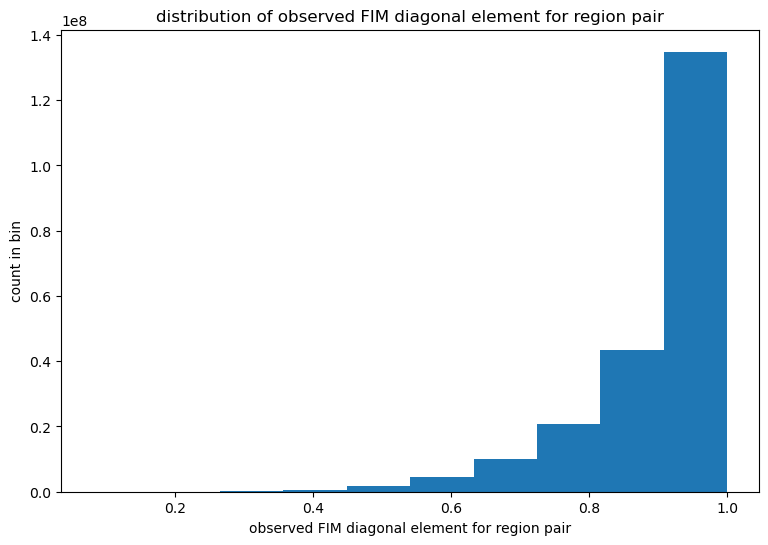

lower quantile 5403847, -1 and +1 tensor(0.6094, device='cuda:0') tensor(0.6094, device='cuda:0') tensor(0.6094, device='cuda:0')
half way point 108076950, -1 and +1 tensor(0.9424, device='cuda:0') tensor(0.9424, device='cuda:0') tensor(0.9424, device='cuda:0')
upper quantile 210750052, -1 and +1 tensor(0.9998, device='cuda:0') tensor(0.9998, device='cuda:0') tensor(0.9998, device='cuda:0')
The distribution of observed FIM diagonal element for region pair values has median 0 with 95% CI [0.609, 1] and range [0.0816, 1].


In [13]:
name = 'observed FIM diagonal element for region pair'
values = edge_variance
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

In [14]:
edge_variance_range_same_subject = edge_variance.max(dim=0).values - edge_variance.min(dim=0).values

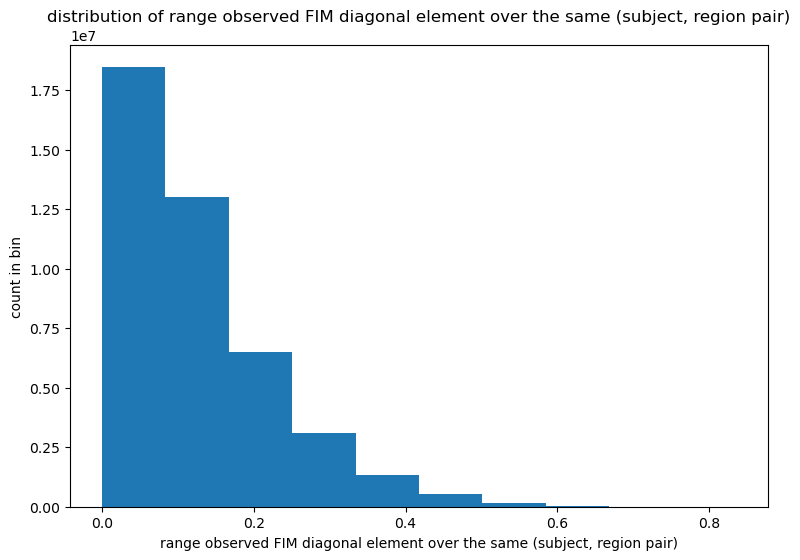

lower quantile 1080769, -1 and +1 tensor(0.0089, device='cuda:0') tensor(0.0089, device='cuda:0') tensor(0.0089, device='cuda:0')
half way point 21615390, -1 and +1 tensor(0.0993, device='cuda:0') tensor(0.0993, device='cuda:0') tensor(0.0993, device='cuda:0')
upper quantile 42150010, -1 and +1 tensor(0.3883, device='cuda:0') tensor(0.3883, device='cuda:0') tensor(0.3883, device='cuda:0')
The distribution of range observed FIM diagonal element over the same (subject, region pair) values has median 0 with 95% CI [0.00887, 0.388] and range [8.29e-06, 0.836].


In [15]:
name = 'range observed FIM diagonal element over the same (subject, region pair)'
values = edge_variance_range_same_subject
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

In [17]:
print_proportions_of_variance_explained( variable_name='edge FIM diagonal element', explainer_name='edge identity', values=edge_variance, dim=(0,1) )

proportion of variance of edge FIM diagonal element explained by edge identity = 0.00289/0.0117 = 0.248. Proportion unexplained = 0.00877/0.0117 = 0.752. F-stat = 0.33. Explained + unexplained = 1.


In [18]:
print_proportions_of_variance_explained( variable_name='edge FIM diagonal element', explainer_name='edge and participant identity', values=edge_variance, dim=0 )

proportion of variance of edge FIM diagonal element explained by edge and participant identity = 0.00808/0.0117 = 0.693. Proportion unexplained = 0.00448/0.0117 = 0.384. F-stat = 1.81. Explained + unexplained = 1.08.


In [23]:
min_node_variance = node_variance.min(dim=0).values.min(dim=0).values
min_edge_variance = edge_variance.min(dim=0).values.min(dim=0).values
num_nodes = min_node_variance.size(dim=-1)
min_variance_square = isingmodel.triu_to_square_pairs( triu_pairs=min_edge_variance.unsqueeze(dim=0), diag_fill=0 ).squeeze(dim=0) + torch.diag_embed(min_node_variance)
print( min_variance_square.size() )

torch.Size([360, 360])


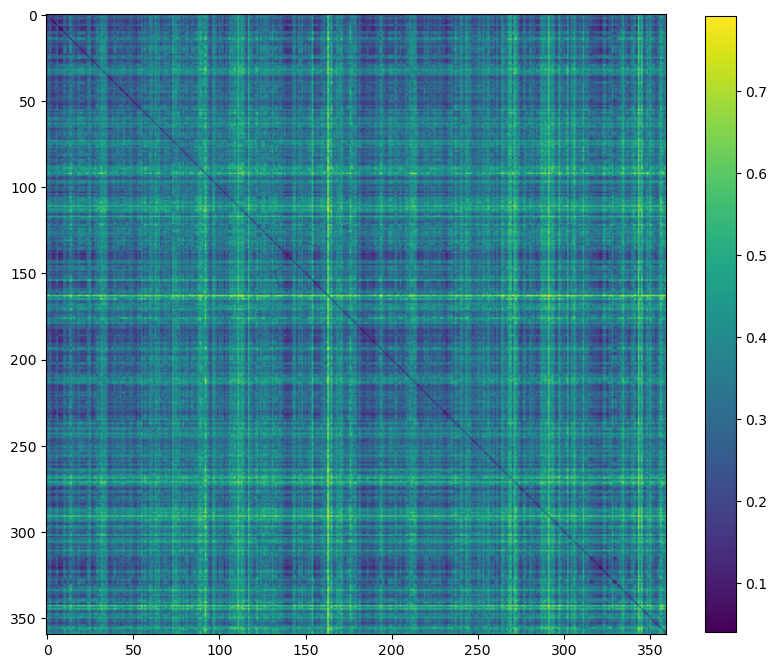

In [31]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 10) )
cbax = axs.imshow( min_variance_square.detach().cpu().numpy() )
fig.colorbar(cbax, shrink=0.8)

In [35]:
print( min_variance_square.min(), min_variance_square.max() )

tensor(0.0396, device='cuda:0') tensor(0.7915, device='cuda:0')


In [32]:
max_node_variance = node_variance.max(dim=0).values.max(dim=0).values
max_edge_variance = edge_variance.max(dim=0).values.max(dim=0).values
num_nodes = max_node_variance.size(dim=-1)
max_variance_square = isingmodel.triu_to_square_pairs( triu_pairs=max_edge_variance.unsqueeze(dim=0), diag_fill=0 ).squeeze(dim=0) + torch.diag_embed(max_node_variance)
print( max_variance_square.size() )

torch.Size([360, 360])


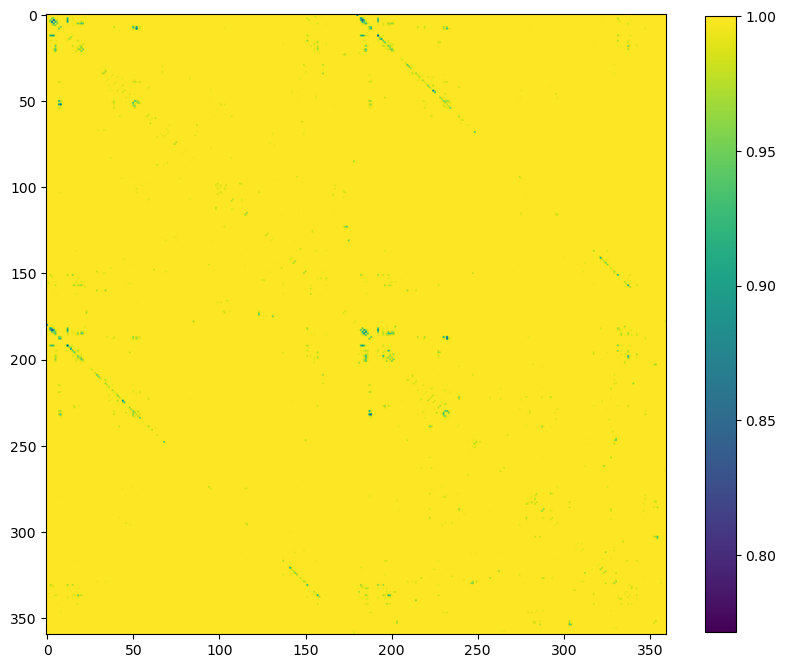

In [33]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(10, 10) )
cbax = axs.imshow( max_variance_square.detach().cpu().numpy() )
fig.colorbar(cbax, shrink=0.8)

In [34]:
print( max_variance_square.min(), max_variance_square.max() )

tensor(0.7712, device='cuda:0') tensor(1., device='cuda:0')


correlation between J and variance of a region pair -0.285


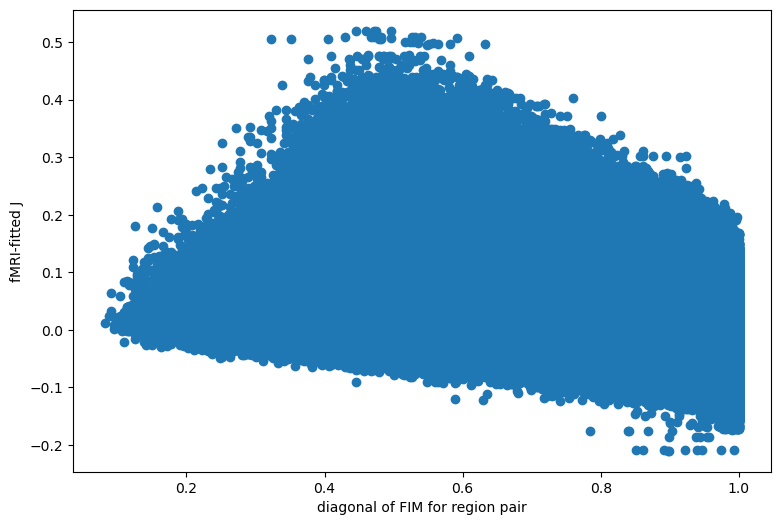

In [48]:
J_variance_correlation = isingmodel.get_pairwise_correlation( mat1=J.flatten(), mat2=edge_variance.flatten() )
print(f'correlation between J and variance of a region pair {J_variance_correlation:.3g}')
make_scatter( xname='diagonal of FIM for region pair', xvalues=edge_variance.flatten(), yname='fMRI-fitted J', yvalues=J.flatten() )

correlation between variance of J and mean of variance of a region pair 0.433


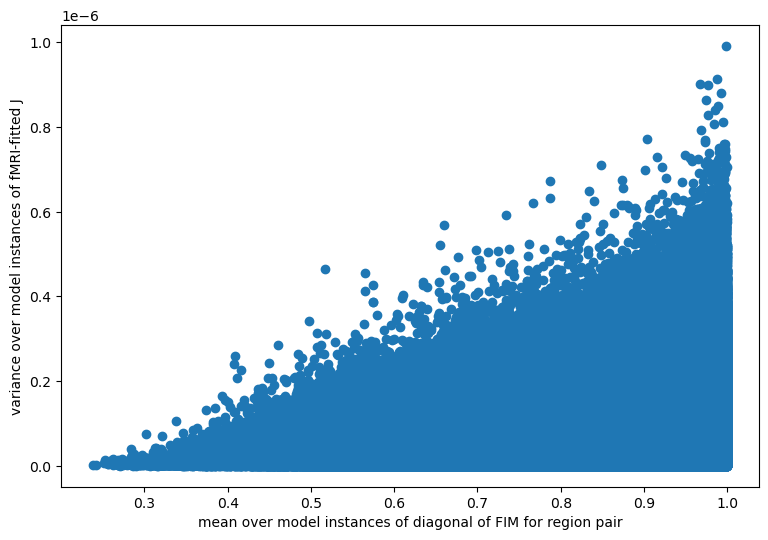

In [50]:
var_J = J.var(dim=0)
mean_edge_variance = edge_variance.mean(dim=0)
J_variance_correlation = isingmodel.get_pairwise_correlation( mat1=var_J.flatten(), mat2=mean_edge_variance.flatten() )
print(f'correlation between variance of J and mean of variance of a region pair {J_variance_correlation:.3g}')
make_scatter( xname='mean over model instances of diagonal of FIM for region pair', xvalues=mean_edge_variance.flatten(), yname='variance over model instances of fMRI-fitted J', yvalues=var_J.flatten() )

correlation between variance of J and mean of variance of a region pair -0.463


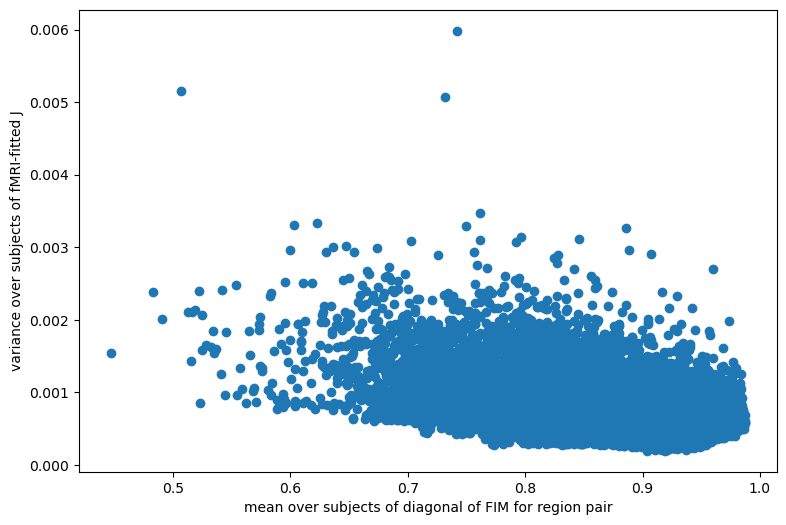

In [52]:
var_J = J.var( dim=(0,1) )
mean_edge_variance = edge_variance.mean( dim=(0,1) )
J_variance_correlation = isingmodel.get_pairwise_correlation( mat1=var_J.flatten(), mat2=mean_edge_variance.flatten() )
print(f'correlation between variance of J and mean of variance of a region pair {J_variance_correlation:.3g}')
make_scatter( xname='mean over subjects of diagonal of FIM for region pair', xvalues=mean_edge_variance.flatten(), yname='variance over subjects of fMRI-fitted J', yvalues=var_J.flatten() )

In [ ]:
J_variance_correlation = isingmodel.get_pairwise_correlation( mat1=J.flatten(), mat2=edge_variance.flatten() )
print(f'correlation between J and variance of a region pair {J_variance_correlation:.3g}')
make_scatter( xname='diagonal of FIM for region pair', xvalues=edge_variance.flatten(), yname='fMRI-fitted J', yvalues=J.flatten() )

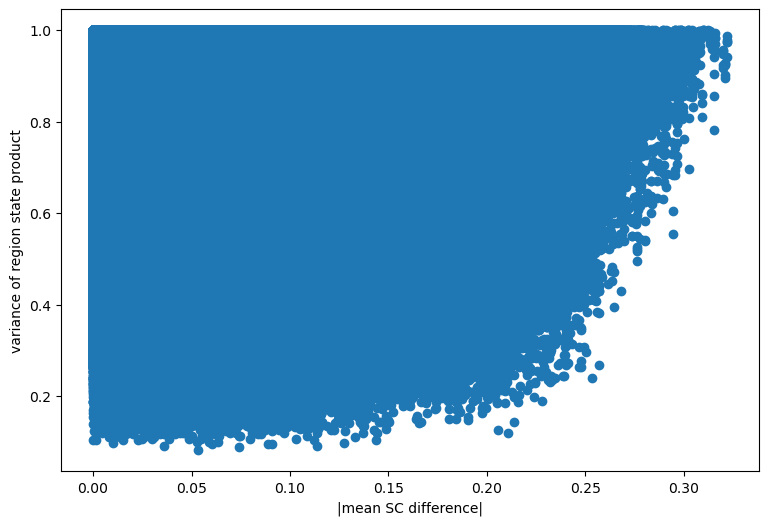

In [85]:
feature_index = 12
models_per_subject = edge_variance.size(dim=0)
make_scatter(  xname=edge_feature_names[feature_index], xvalues=edge_features[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='variance of region state product', yvalues=edge_variance)

In [86]:
node_features_diff_file = os.path.join(file_dir, 'node_features_diff_group_training_and_individual_all_signed_params_times_beta.pt')
node_features_diff = torch.load(node_features_diff_file)
print( node_features_diff.size() )

torch.Size([669, 360, 5])


In [87]:
h_diff_file = os.path.join(file_dir, 'h_diff_group_training_and_individual_all_signed_params_times_beta.pt')
h_diff = torch.load(h_diff_file)
print( h_diff.size() )

torch.Size([5, 669, 360])


In [9]:
node_feature_names_no_coords = ['mean SC', 'thickness', 'myelination', 'curvature', 'sulcus depth']
edge_feature_names_no_coords = ['SC'] + [f'|{pname} difference|' for pname in node_feature_names_no_coords]
node_feature_diff_names = [f'offset from mean {name}' for name in node_feature_names_no_coords]
edge_feature_diff_names = [f'offset from mean {name}' for name in edge_feature_names_no_coords]

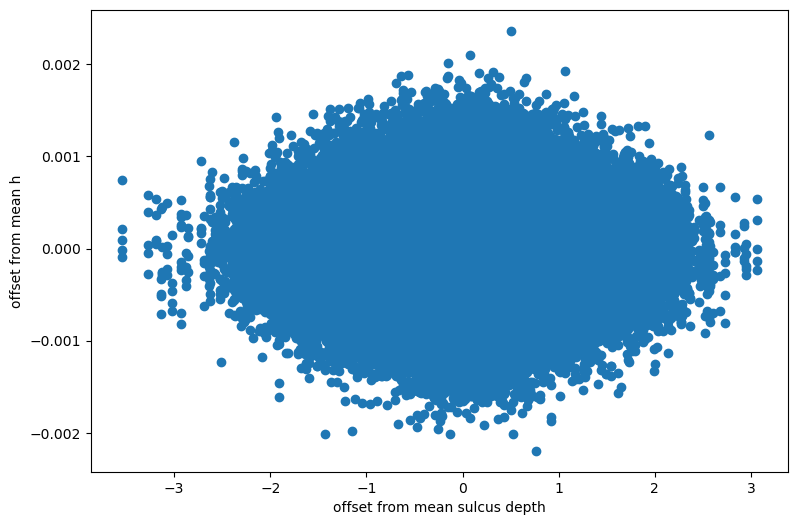

In [95]:
feature_index = 4
models_per_subject = h_diff.size(dim=0)
make_scatter(  xname=node_feature_diff_names[feature_index], xvalues=node_features_diff[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='offset from mean h', yvalues=h_diff)

In [10]:
edge_features_diff_file = os.path.join(file_dir, 'edge_features_diff_group_training_and_individual_all_signed_params_times_beta.pt')
edge_features_diff = torch.load(edge_features_diff_file)
print( edge_features_diff.size() )

torch.Size([669, 64620, 6])


In [11]:
J_diff_file = os.path.join(file_dir, 'J_diff_group_training_and_individual_all_signed_params_times_beta.pt')
J_diff = torch.load(J_diff_file)
print( J_diff.size() )

torch.Size([5, 669, 64620])


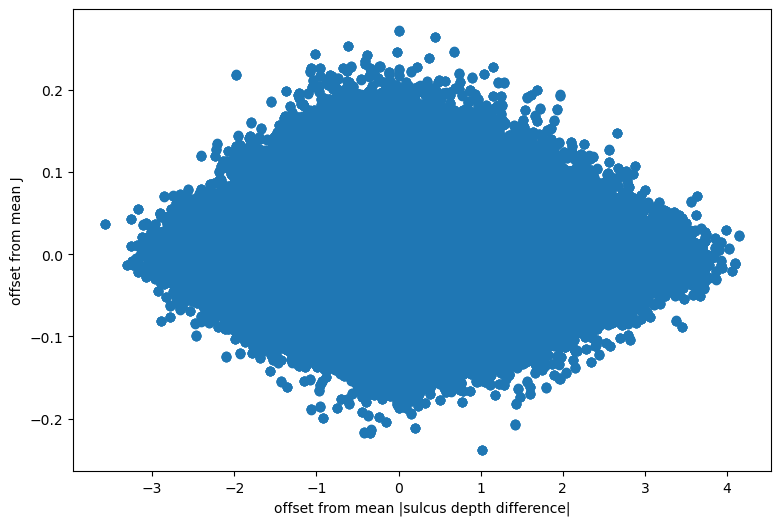

In [18]:
feature_index = 5
models_per_subject = J_diff.size(dim=0)
make_scatter(  xname=edge_feature_diff_names[feature_index], xvalues=edge_features_diff[:,:,feature_index].unsqueeze(dim=0).repeat( (models_per_subject,1,1) ), yname='offset from mean J', yvalues=J_diff)

In [51]:
print( 223*2*3*(5**2) )

33450


correlation between variance of h in bin and mean of mean SC in bin is 0.958


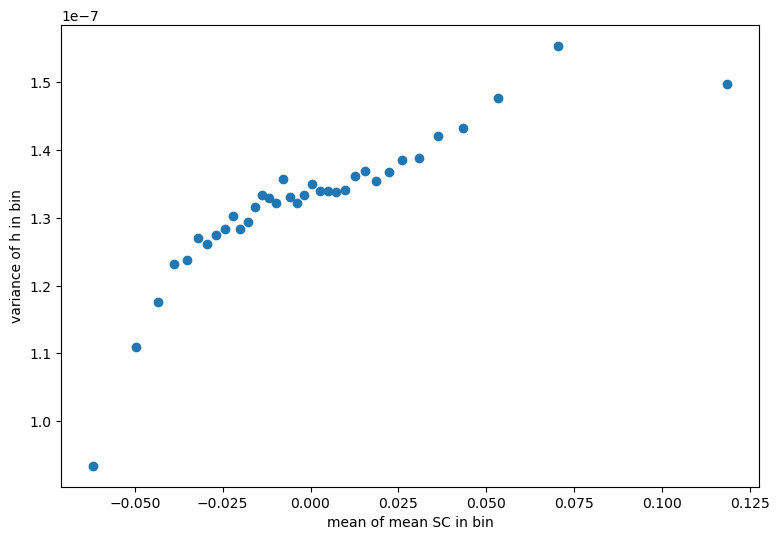

In [63]:
bin_size = 33450
feature_index = 10
feature_means, h_vars = bin_feature_mean_param_var(feature=node_features[:,:,feature_index], param=h, bin_size=bin_size)
mean_var_correlation = isingmodel.get_pairwise_correlation(mat1=feature_means, mat2=h_vars)
node_feature_name = node_feature_names[feature_index]
print(f'correlation between variance of h in bin and mean of {node_feature_name} in bin is {mean_var_correlation:.3g}')
make_scatter(  xname=f'mean of {node_feature_name} in bin', xvalues=feature_means, yname='variance of h in bin', yvalues=h_vars)

In [69]:
print(5*669*64620//36)

6004275


In [14]:
bin_size = 33450
feature_index = 0
feature_means, J_vars = bin_feature_mean_param_var(feature=edge_features[:,:,feature_index], param=J, bin_size=bin_size)
mean_var_correlation = isingmodel.get_pairwise_correlation(mat1=feature_means, mat2=J_vars)
edge_feature_name = edge_feature_names[feature_index]
print(f'correlation between variance of J in bin and mean of {edge_feature_name} in bin is {mean_var_correlation:.3g}')
make_scatter(  xname=f'mean of {edge_feature_name} in bin', xvalues=feature_means, yname='variance of J in bin', yvalues=J_vars)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.61 GiB (GPU 0; 8.00 GiB total capacity; 6.12 GiB already allocated; 478.62 MiB free; 6.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [146]:
# Compute the means and std devs of the bins in a separate script.
# Then plot them here.
file_name_fragment = 'group_training_and_individual_all_signed_params_rectangular_coords_times_beta'
is_edge = True
if is_edge:
    param_name = 'J'
    feature_names = edge_feature_names
    feature_names_for_file = edge_feature_names_for_files
    bin_size = 6004275
else:
    param_name = 'h'
    feature_names = node_feature_names
    feature_names_for_file = node_feature_names_for_files
    bin_size = 33450
feature_index = 12
feature_name_for_file = feature_names_for_file[feature_index]
feature_name = feature_names[feature_index]
binned_std_mean_file = os.path.join(file_dir, f'binned_{param_name}_{feature_name_for_file}_std_mean_{file_name_fragment}_bin_size_{bin_size}.pt')
feature_stds, feature_means, param_stds, param_means = torch.load(binned_std_mean_file)
print( 'feature_stds size', feature_stds.size() )
print( 'feature_means size', feature_means.size() )
print( 'param_stds size', param_stds.size() )
print( 'param_means size', param_means.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.errorbar( x=feature_means.flatten().detach().cpu().numpy(), y=param_means.flatten().detach().cpu().numpy(), xerr=feature_stds.flatten().detach().cpu().numpy(), yerr=param_stds.flatten().detach().cpu().numpy(), linestyle='' )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel(f'mean and standard deviation of {feature_name}')
axs.set_ylabel(f'mean and standard deviation of {param_name}')
# axs.set_xlim(left=-0.145, right=-0)
# axs.set_title(f'{xname} vs {yname}')
fig_dir = 'C:\\Users\\agcraig\\Documents\\GitHub\\MachineLearningNeuralMassModel\\IsingModel\\figures'
fig_file_name = os.path.join(fig_dir, f'errorbar_{param_name}_vs_{feature_name_for_file}_bin_size_{bin_size}.png')
plt.savefig(fig_file_name)
print(f'saved {fig_file_name}')
plt.show()

feature_stds size torch.Size([36])
feature_means size torch.Size([36])
param_stds size torch.Size([36])
param_means size torch.Size([36])
saved C:\Users\agcraig\Documents\GitHub\MachineLearningNeuralMassModel\IsingModel\figures\errorbar_J_vs_mean_sc_difference_bin_size_6004275.png


feature_stds size torch.Size([36])
feature_means size torch.Size([36])
param_stds size torch.Size([36])
param_means size torch.Size([36])
saved C:\Users\agcraig\Documents\GitHub\MachineLearningNeuralMassModel\IsingModel\figures\errorbar_J_vs_log10_mean_sc_difference_bin_size_6004275.png


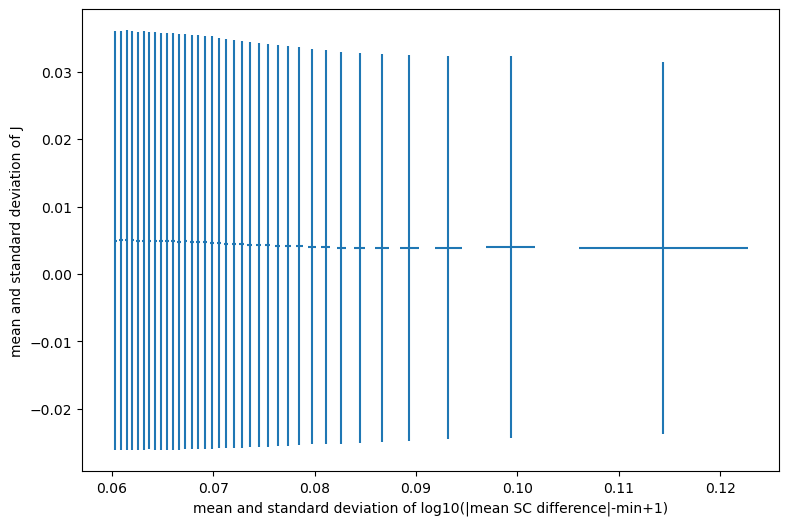

In [147]:
# Compute the means and std devs of the bins in a separate script.
# Then plot them here.
file_name_fragment = 'group_training_and_individual_all_signed_params_rectangular_coords_times_beta'
is_edge = True
if is_edge:
    param_name = 'J'
    feature_names = edge_feature_names
    feature_names_for_file = edge_feature_names_for_files
    bin_size = 6004275
else:
    param_name = 'h'
    feature_names = node_feature_names
    feature_names_for_file = node_feature_names_for_files
    bin_size = 33450
feature_index = 12
feature_name_for_file = feature_names_for_file[feature_index]
feature_name = feature_names[feature_index]
binned_std_mean_file = os.path.join(file_dir, f'binned_{param_name}_log10_{feature_name_for_file}_std_mean_{file_name_fragment}_bin_size_{bin_size}.pt')
feature_stds, feature_means, param_stds, param_means = torch.load(binned_std_mean_file)
print( 'feature_stds size', feature_stds.size() )
print( 'feature_means size', feature_means.size() )
print( 'param_stds size', param_stds.size() )
print( 'param_means size', param_means.size() )
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.errorbar( x=feature_means.flatten().detach().cpu().numpy(), y=param_means.flatten().detach().cpu().numpy(), xerr=feature_stds.flatten().detach().cpu().numpy(), yerr=param_stds.flatten().detach().cpu().numpy(), linestyle='' )
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs.set_xlabel(f'mean and standard deviation of log10({feature_name}-min+1)')
axs.set_ylabel(f'mean and standard deviation of {param_name}')
# axs.set_xlim(left=-0.145, right=-0)
# axs.set_title(f'{xname} vs {yname}')
fig_dir = 'C:\\Users\\agcraig\\Documents\\GitHub\\MachineLearningNeuralMassModel\\IsingModel\\figures'
fig_file_name = os.path.join(fig_dir, f'errorbar_{param_name}_vs_log10_{feature_name_for_file}_bin_size_{bin_size}.png')
plt.savefig(fig_file_name)
print(f'saved {fig_file_name}')

In [152]:
test_tensor = torch.tensor([1.0, 1.0], dtype=float_type, device=device)
print(test_tensor)
test_std, test_mean = torch.std_mean(test_tensor)
print(test_std, test_mean)

tensor([1., 1.], device='cuda:0')
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [116]:
fc_rmse_h_yes_file = os.path.join(file_dir, f'fc_rmse_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_yes.pt')
fc_rmse_h_yes = torch.load(fc_rmse_h_yes_file)
print( fc_rmse_h_yes.size() )

torch.Size([4190])


In [117]:
fc_rmse_h_no_file = os.path.join(file_dir, f'fc_rmse_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_no.pt')
fc_rmse_h_no = torch.load(fc_rmse_h_no_file)
print( fc_rmse_h_no.size() )

torch.Size([4190])


In [118]:
fc_rmse_diff = fc_rmse_h_no - fc_rmse_h_yes

The distribution of FC RMSE with h zeroed - with fitted h values values has median -3.94e-05 with 95% CI [-0.0205, 0.0192] and range [-0.0425, 0.0504].


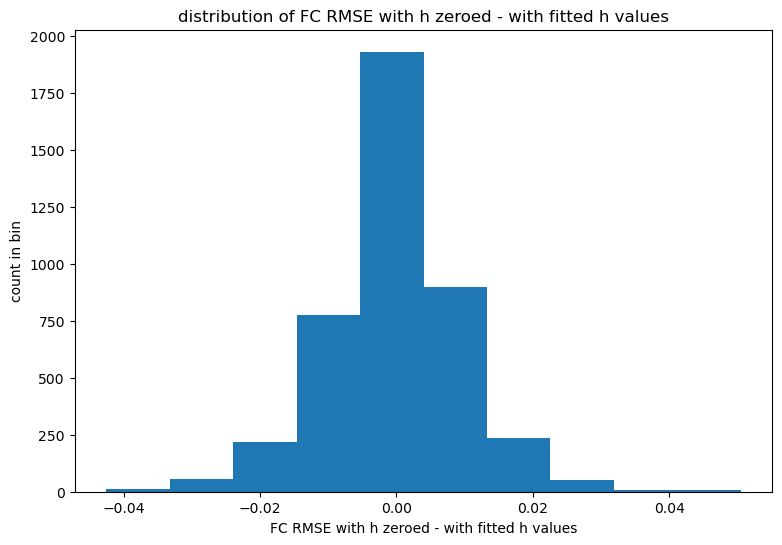

In [119]:
name = 'FC RMSE with h zeroed - with fitted h values'
values = fc_rmse_diff
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

In [120]:
t_test_result = stats.ttest_1samp( a=fc_rmse_diff.detach().cpu().numpy(), popmean=0, axis=0, nan_policy='propagate', alternative='two-sided', keepdims=False )
print(t_test_result)

TtestResult(statistic=-1.3519932345853893, pvalue=0.1764504689003882, df=4189)


In [121]:
fc_rmse_diff_testing = fc_rmse_diff.unflatten( dim=0, sizes=(5,-1) )[:,1:670].mean(dim=0)
print( fc_rmse_diff_testing.size() )

torch.Size([669])


In [122]:
t_test_result = stats.ttest_1samp( a=fc_rmse_diff_testing.detach().cpu().numpy(), popmean=0, axis=0, nan_policy='propagate', alternative='two-sided', keepdims=False )
print(t_test_result)

TtestResult(statistic=-2.0093371252069367, pvalue=0.044903155870964356, df=668)


The distribution of intra-subject mean FC RMSE with h zeroed - with fitted h values values has median -0.000578 with 95% CI [-0.00907, 0.00868] and range [-0.0175, 0.0146].


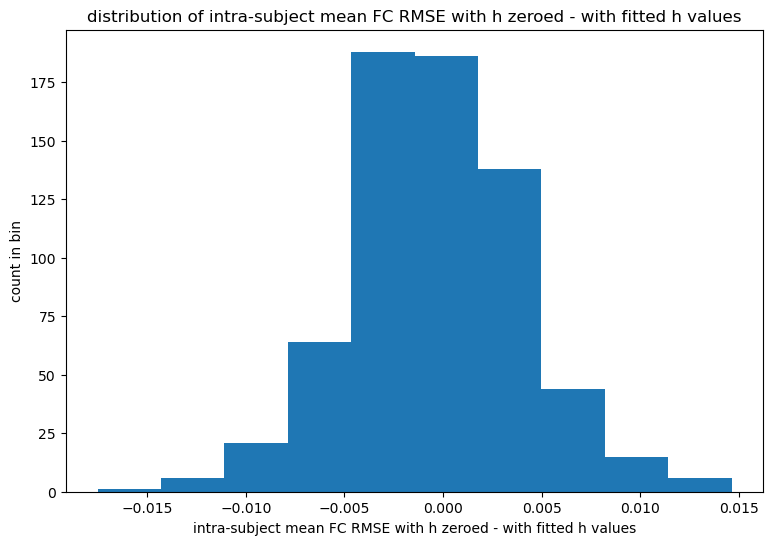

In [123]:
name = 'intra-subject mean FC RMSE with h zeroed - with fitted h values'
values = fc_rmse_diff_testing
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

torch.Size([669])
TtestResult(statistic=-1.627391867795245, pvalue=0.10412545358597196, df=668)
The distribution of difference in FC RMSE between Ising models with h=0 and with fitted h values values has median -0.000277 with 95% CI [-0.0217, 0.0185] and range [-0.0357, 0.0443].


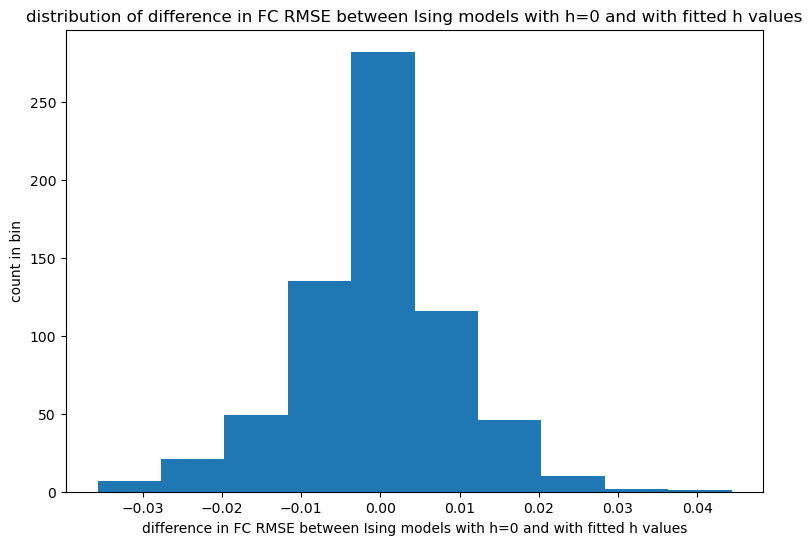

In [124]:
fc_rmse_diff_first_rep_training = fc_rmse_diff.unflatten( dim=0, sizes=(5,-1) )[0,1:670]
print( fc_rmse_diff_first_rep_training.size() )
t_test_result = stats.ttest_1samp( a=fc_rmse_diff_first_rep_training.detach().cpu().numpy(), popmean=0, axis=0, nan_policy='propagate', alternative='two-sided', keepdims=False )
print(t_test_result)
name = 'difference in FC RMSE between Ising models with h=0 and with fitted h values'
values = fc_rmse_diff_first_rep_training
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

In [125]:
fc_rmse_h_yes_training = fc_rmse_h_yes.unflatten( dim=0, sizes=(5,-1) )[:,1:670]
print( fc_rmse_h_yes_training.size() )
fc_rmse_h_no_training = fc_rmse_h_no.unflatten( dim=0, sizes=(5,-1) )[:,1:670]
print( fc_rmse_h_no_training.size() )

torch.Size([5, 669])
torch.Size([5, 669])


correlation between FC RMSE from simulation with fitted h and simulation with zeroed h 0.949


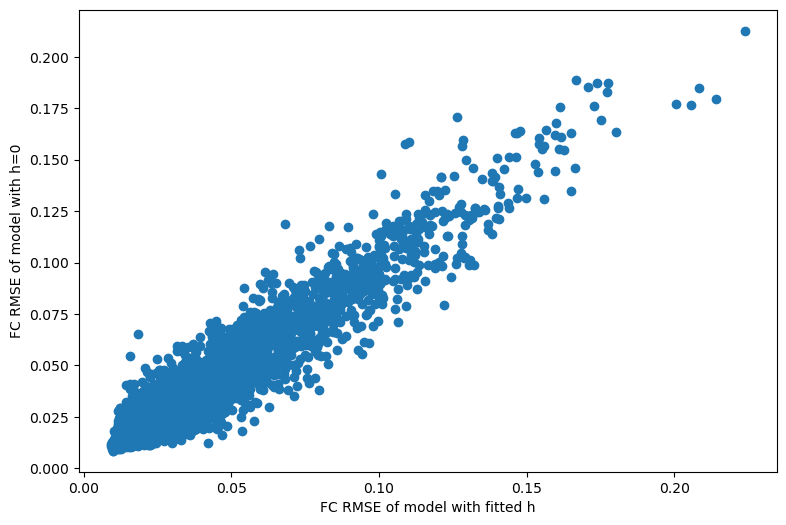

In [126]:
rmse_h_yes_no_correlation = isingmodel.get_pairwise_correlation( mat1=fc_rmse_h_yes_training.flatten(), mat2=fc_rmse_h_no_training.flatten() )
print(f'correlation between FC RMSE from simulation with fitted h and simulation with zeroed h {rmse_h_yes_no_correlation:.3g}')
make_scatter( xname='FC RMSE of model with fitted h', xvalues=fc_rmse_h_yes_training.flatten(), yname='FC RMSE of model with h=0', yvalues=fc_rmse_h_no_training.flatten() )

In [219]:
fc_rmse_h_yes_file_1 = os.path.join(file_dir, f'fc_rmse_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_yes_J_fit.pt')
fc_rmse_h_yes_1 = torch.load(fc_rmse_h_yes_file_2)
print( fc_rmse_h_yes_1.size() )
fc_rmse_h_yes_training_1 = fc_rmse_h_yes_2.unflatten( dim=0, sizes=(5,-1) )[:,1:670]
print( fc_rmse_h_yes_training_1.size() )
fc_rmse_h_yes_file_2 = os.path.join(file_dir, f'fc_rmse_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_yes_J_fit_retest.pt')
fc_rmse_h_yes_2 = torch.load(fc_rmse_h_yes_file_2)
print( fc_rmse_h_yes_2.size() )
fc_rmse_h_yes_training_2 = fc_rmse_h_yes_2.unflatten( dim=0, sizes=(5,-1) )[:,1:670]
print( fc_rmse_h_yes_training_2.size() )

torch.Size([4190])
torch.Size([5, 669])
torch.Size([4190])
torch.Size([5, 669])


correlation between FC RMSE values from separate simulations of the same model 0.944


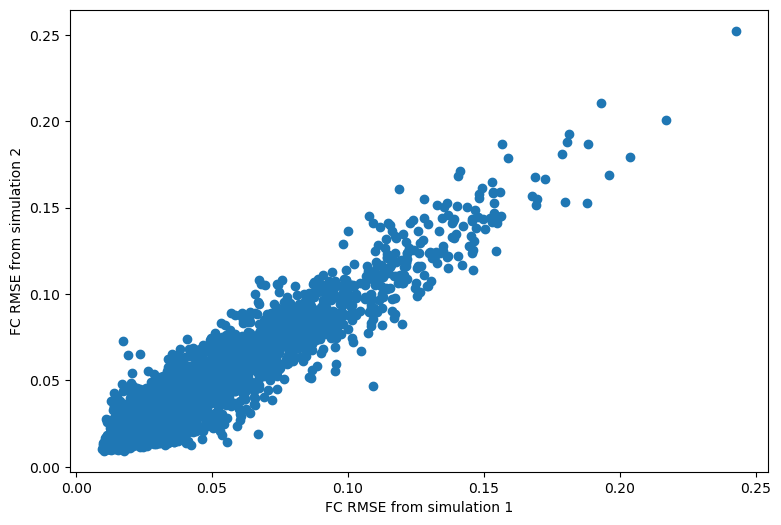

In [220]:
rmse_h_yes_yes_correlation = isingmodel.get_pairwise_correlation( mat1=fc_rmse_h_yes_training_1.flatten(), mat2=fc_rmse_h_yes_training_2.flatten() )
print(f'correlation between FC RMSE values from separate simulations of the same model {rmse_h_yes_yes_correlation:.3g}')
make_scatter( xname='FC RMSE from simulation 1', xvalues=fc_rmse_h_yes_training_1.flatten(), yname='FC RMSE from simulation 2', yvalues=fc_rmse_h_yes_training_2.flatten() )

The distribution of FC RMSE from first test simulation values has median 0.0344 with 95% CI [0.0121, 0.127] and range [0.00922, 0.224].


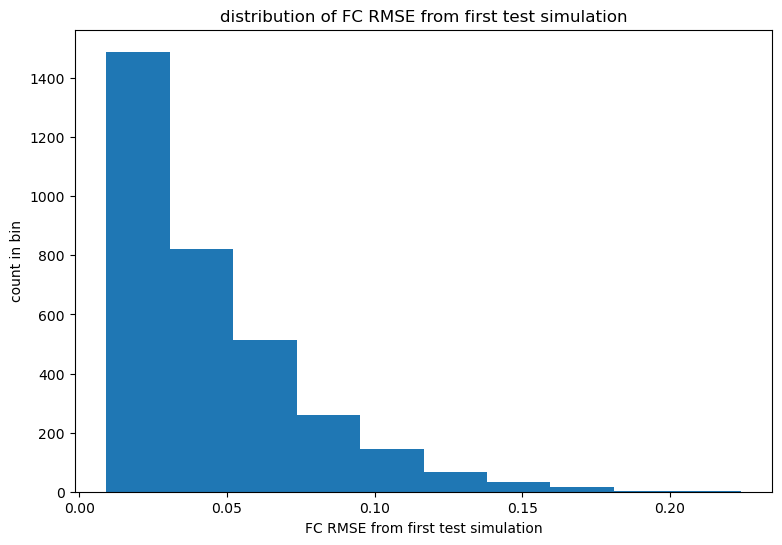

In [129]:
name='FC RMSE from first test simulation'
values=fc_rmse_h_yes_training
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

The distribution of FC RMSE from second test simulation values has median 0.0344 with 95% CI [0.0122, 0.128] and range [0.00949, 0.243].


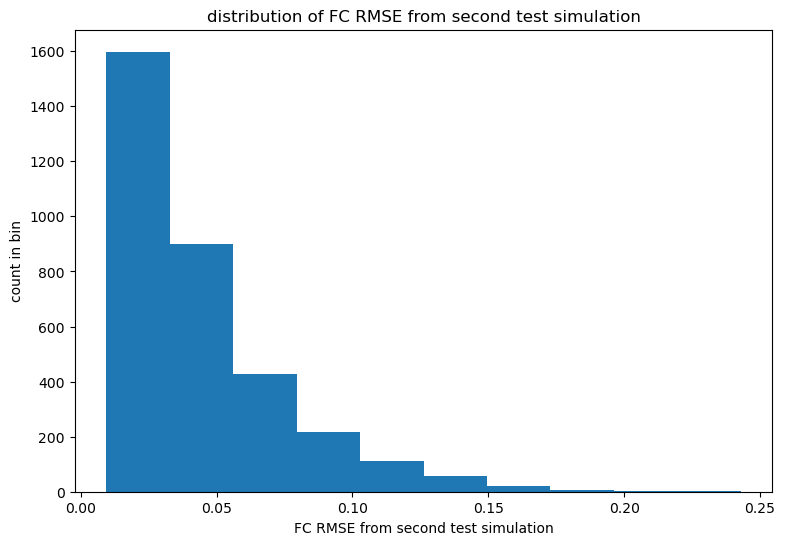

In [130]:
name='FC RMSE from second test simulation'
values=fc_rmse_h_yes_training_2
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

In [26]:
fc_rmse_J_fc_file = os.path.join(file_dir, f'fc_rmse_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_no_J_fc.pt')
fc_rmse_J_fc = torch.load(fc_rmse_J_fc_file)
print( fc_rmse_J_fc.size() )

torch.Size([4190])


In [28]:
name = 'FC RMSE with fitted J values - with fitted covariances matrix for J'
values = fc_rmse_diff
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

The distribution of FC RMSE with fitted J values - with fitted covariances matrix for J values has median -0.0774 with 95% CI [-0.361, 0.0206] and range [-0.504, 0.112].


In [29]:
t_test_result = stats.ttest_1samp( a=fc_rmse_diff.detach().cpu().numpy(), popmean=0, axis=0, nan_policy='propagate', alternative='two-sided', keepdims=False )
print(t_test_result)

TtestResult(statistic=-73.5754685920448, pvalue=0.0, df=4189)


In [31]:
w_test_result = stats.wilcoxon(x=fc_rmse_diff.detach().cpu().numpy(), y=None, zero_method='wilcox', correction=False, alternative='two-sided', method='auto', nan_policy='propagate', keepdims=False)
print(w_test_result)

WilcoxonResult(statistic=112027.0, pvalue=0.0)


In [33]:
fc_rmse_diff = fc_rmse_h_no - fc_rmse_J_fc
fc_rmse_diff_first_rep_training = fc_rmse_diff.unflatten( dim=0, sizes=(5,-1) )[0,1:670]
print( fc_rmse_diff_first_rep_training.size() )
# t_test_result = stats.ttest_1samp( a=fc_rmse_diff_first_rep_training.detach().cpu().numpy(), popmean=0, axis=0, nan_policy='propagate', alternative='two-sided', keepdims=False )
# print(t_test_result)
w_test_result = stats.wilcoxon(x=fc_rmse_diff_first_rep_training.detach().cpu().numpy(), y=None, zero_method='wilcox', correction=False, alternative='two-sided', method='auto', nan_policy='propagate', keepdims=False)
print(w_test_result)
name = 'difference in FC RMSE between Ising models with J=covariance and with fitted J values'
values = fc_rmse_diff_first_rep_training
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

torch.Size([669])
WilcoxonResult(statistic=3848.0, pvalue=7.773789906075075e-104)
The distribution of difference in FC RMSE between Ising models with J=covariance and with fitted J values values has median -0.078 with 95% CI [-0.36, 0.0317] and range [-0.482, 0.0972].


In [169]:
models_per_subject, num_subjects, num_nodes = h.size()
h_flat = h.flatten()
h_diffs_pairwise = torch.abs(h_flat[:,None] - h_flat[None,:])
subject_index = torch.arange(num_subjects, dtype=int_type, device=h.device).unsqueeze(dim=0).unsqueeze(dim=-1).repeat( (models_per_subjecct,1,num_nodes) ).flatten()
is_same_subject = subject_index[:,None] == subject_index[None,:]
node_index = torch.arange(num_nodes, dtype=int_type, device=h.device).unsqueeze(dim=0).unsqueeze(dim=0).repeat( (models_per_subjecct,num_subjects,1) ).flatten()
is_same_node = node_index[:,None] == node_index[None,:]
is_same_subject_and_node = torch.logical_and(is_same_subject, is_same_node)
print( 'num same subject and node pairs', torch.count_nonzero(is_same_subject_and_node) )
is_different_subject_same_node = torch.logical_and( torch.logical_not(is_same_subject), is_same_node )
print( 'num different subject, same node pairs', torch.count_nonzero(is_different_subject_same_node) )
is_different_node = torch.logical_not(is_same_node)
print( 'num different node pairs', torch.count_nonzero(is_different_node) )

OutOfMemoryError: CUDA out of memory. Tried to allocate 5402.04 GiB (GPU 0; 8.00 GiB total capacity; 4.65 MiB already allocated; 6.57 GiB free; 22.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [172]:
h_min_over_instances = h.min(dim=0).values
h_max_over_instances = h.max(dim=0).values
same_subject_same_node_ranges = h_max_over_instances - h_min_over_instances
print( same_subject_same_node_ranges.size() )
h_min_over_subjects = h_min_over_instances.min(dim=0).values
h_max_over_subjects = h_max_over_instances.max(dim=0).values
same_node_ranges = h_max_over_subjects - h_min_over_subjects
print( same_node_ranges.size() )
h_min_total = h_min_over_subjects.min()
h_max_total = h_max_over_subjects.max()
total_range = h_max_total - h_min_total
print( total_range.size() )

torch.Size([669, 360])
torch.Size([360])
torch.Size([])


In [173]:
print(f'total range of h values {total_range:.3g}')

total range of h values 0.00457


The distribution of range of h values in the same region values has median 0.00285 with 95% CI [0.00206, 0.00354] and range [0.00163, 0.00393].


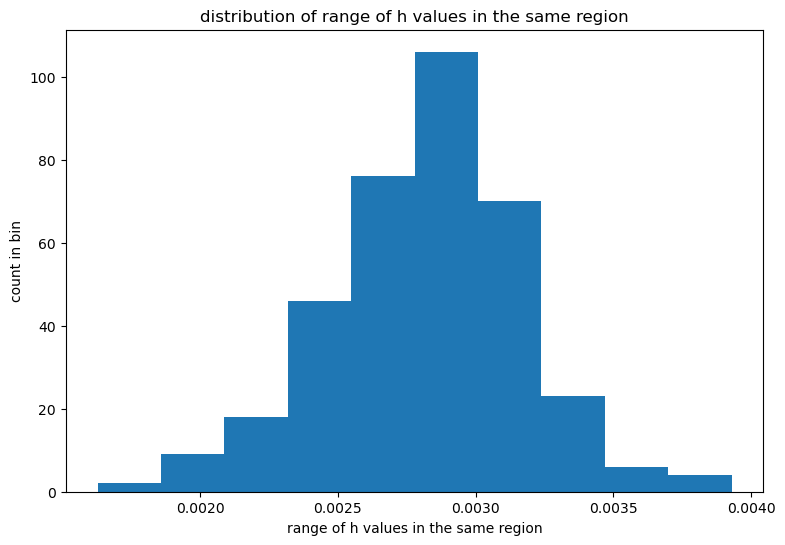

In [174]:
name = 'range of h values in the same region'
values = same_node_ranges
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

The distribution of range of h values for the same region of the same subject values has median 0.000794 with 95% CI [0.000286, 0.00161] and range [3.55e-05, 0.00315].


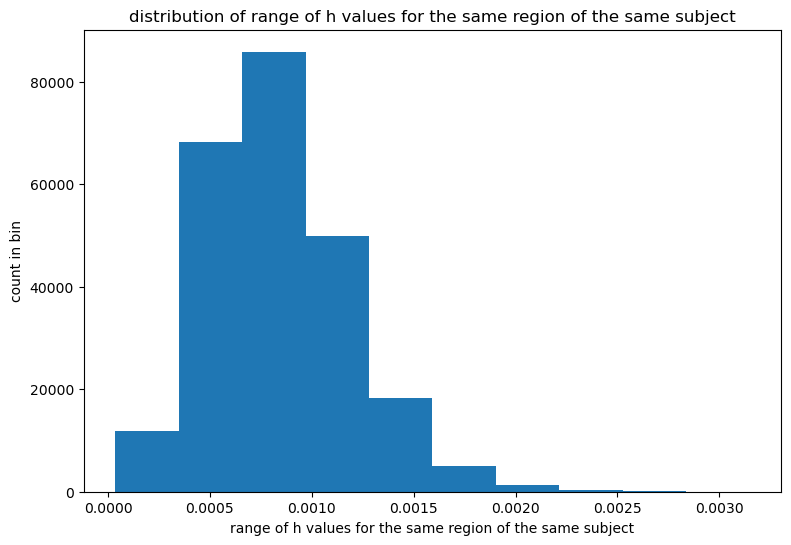

In [175]:
name = 'range of h values for the same region of the same subject'
values = same_subject_same_node_ranges
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

In [106]:
same_subject_same_node_variances = h.var(dim=0)
print( same_subject_same_node_variances.size() )
same_node_variances = h.var( dim=(0,1) )
print( same_node_variances.size() )
total_variance = h.var()
print( total_variance.size() )

torch.Size([669, 360])
torch.Size([360])
torch.Size([])


In [93]:
print(f'total variance of h values {total_variance:.3g}')

total variance of h values 0.000907


The distribution of variance of h values in the same region values has median 1.35e-07 with 95% CI [7.22e-08, 1.76e-07] and range [5.1e-08, 1.87e-07].


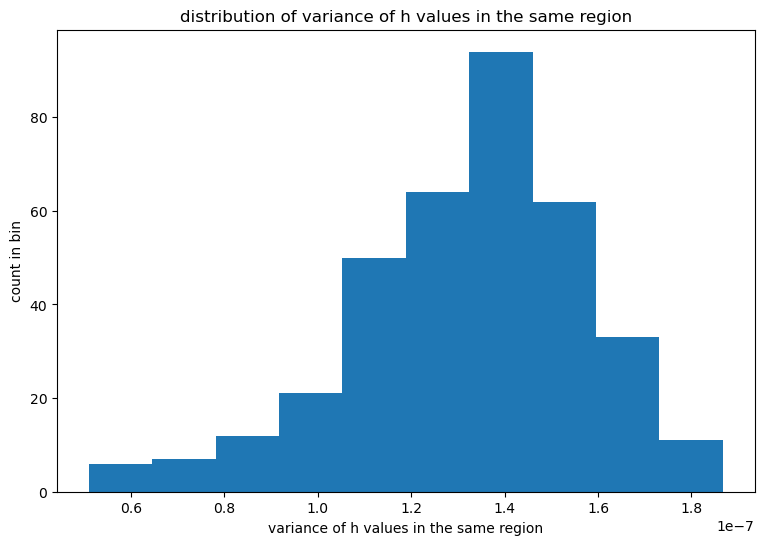

In [94]:
name = 'variance of h values in the same region'
values = same_node_variances
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

In [179]:
name = 'variance of h values for the same region of the same subject'
values = same_subject_same_node_variances
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

The distribution of variance of h values for the same region of the same subject values has median 1.04e-07 with 95% CI [1.37e-08, 4.14e-07] and range [2e-10, 1.55e-06].


In [100]:
print_proportions_of_variance_explained( variable_name='h', explainer_name='node identity', values=h, dim=(0,1) )

proportion of variance of h explained by node identity = 2.5e-11/1.32e-07 = 0.000189. Proportion unexplained = 1.32e-07/1.32e-07 = 1. F-stat = 0.000189. Explained + unexplained = 1.


In [101]:
print_proportions_of_variance_explained( variable_name='h', explainer_name='subject and node identity', values=h, dim=0 )

proportion of variance of h explained by subject and node identity = 2.67e-08/1.32e-07 = 0.202. Proportion unexplained = 1.32e-07/1.32e-07 = 0.998. F-stat = 0.202. Explained + unexplained = 1.2.


In [70]:
same_subject_same_edge_variances = J.var(dim=0)
print( same_subject_same_edge_variances.size() )
same_edge_variances = J.var( dim=(0,1) )
print( same_edge_variances.size() )
total_edge_variance = J.var()
print( total_edge_variance.size() )
print(f'total variance of J values {total_edge_variance:.3g}')

torch.Size([669, 64620])
torch.Size([64620])
torch.Size([])
total variance of J values 0.000907


The distribution of variance of J values of the same region pair values has median 0.000548 with 95% CI [0.000329, 0.00123] and range [0.000194, 0.00599].


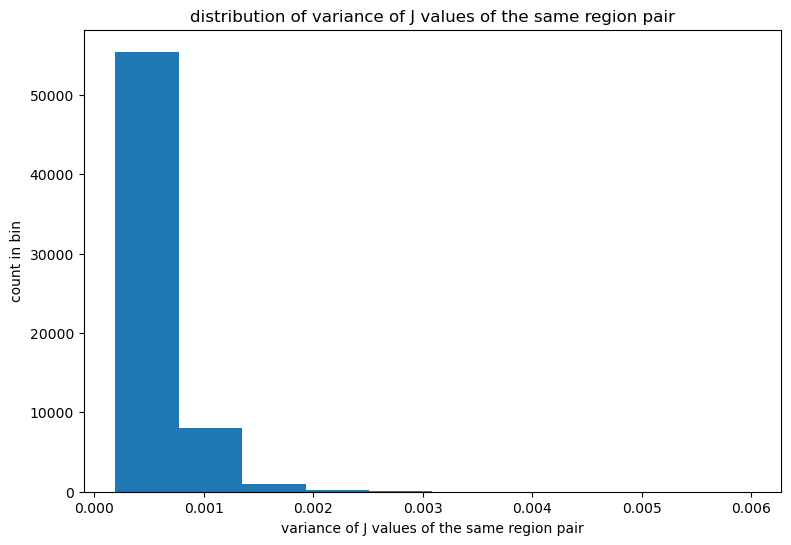

In [108]:
name = 'variance of J values of the same region pair'
values = same_edge_variances
print_stats(name=name, values=values)
make_histogram(name=name, values=values)

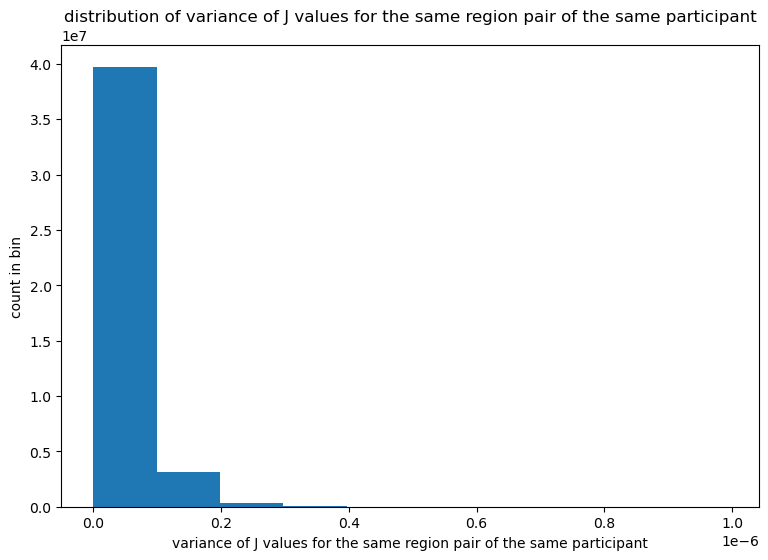

lower quantile 1080769, -1 and +1 tensor(3.4273e-09, device='cuda:0') tensor(3.4273e-09, device='cuda:0') tensor(3.4273e-09, device='cuda:0')
half way point 21615390, -1 and +1 tensor(2.9730e-08, device='cuda:0') tensor(2.9730e-08, device='cuda:0') tensor(2.9730e-08, device='cuda:0')
upper quantile 42150010, -1 and +1 tensor(1.5015e-07, device='cuda:0') tensor(1.5015e-07, device='cuda:0') tensor(1.5015e-07, device='cuda:0')
The distribution of variance of J values for the same region pair of the same participant values has median 0 with 95% CI [3.43e-09, 1.5e-07] and range [1.17e-12, 9.92e-07].


In [109]:
name = 'variance of J values for the same region pair of the same participant'
values = same_subject_same_edge_variances
make_histogram(name=name, values=values)
print_stats_too_big(name=name, values=values)

In [102]:
print_proportions_of_variance_explained( variable_name='J', explainer_name='edge identity', values=J, dim=(0,1) )

proportion of variance of J explained by edge identity = 0.000308/0.000907 = 0.339. Proportion unexplained = 0.0006/0.000907 = 0.661. F-stat = 0.513. Explained + unexplained = 1.


In [103]:
print_proportions_of_variance_explained( variable_name='J', explainer_name='subject and edge identity', values=J, dim=0 )

proportion of variance of J explained by subject and edge identity = 0.000907/0.000907 = 1. Proportion unexplained = 4.18e-08/0.000907 = 4.61e-05. F-stat = 2.17e+04. Explained + unexplained = 1.


In [104]:
print( h.size() )
print( J.size() )

torch.Size([5, 669, 360])
torch.Size([5, 669, 64620])


In [203]:
print( J.size() )
models_per_subject, num_subject, num_pairs = J.size()
J_square = isingmodel.triu_to_square_pairs( triu_pairs=J.flatten(start_dim=0, end_dim=1), diag_fill=0.0 ).unflatten( dim=0, sizes=(models_per_subject, num_subjects) )
print( J_square.size() )

torch.Size([5, 669, 64620])
torch.Size([5, 669, 360, 360])


In [207]:
mean_abs_J = J_square.abs().mean(dim=-1, keepdim=False)
print( mean_abs_J.size() )

torch.Size([5, 669, 360])
torch.Size([5, 669, 360])


In [21]:
abs_h = h.abs()
print( abs_h.size() )

torch.Size([5, 669, 360])


In [209]:
abs_h_mean_abs_J_correlation = isingmodel.get_pairwise_correlation( mat1=abs_h.flatten(), mat2=mean_abs_J.flatten() )
print(f'correlation between absolute value of h and mean of absolute value of J is {abs_h_mean_abs_J_correlation:.3g}')
make_scatter(  xname=f'mean of absolute value of J', xvalues=mean_abs_J, yname='absolute value of h', yvalues=abs_h)

correlation between absolute value of h and mean of absolute value of J is 0.0654


In [19]:
num_steps = 120000
flip_count_file = os.path.join(file_dir, f'flip_count_sim_length_{num_steps}_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_no.pt')
flip_count = torch.load(flip_count_file)
print( flip_count.size() )
flip_count = flip_count.unflatten( dim=0, sizes=(models_per_subject, -1) )
print( flip_count.size() )
flip_count_training = flip_count[:,1:670,:]
print( flip_count_training.size() )
flip_frequency = flip_count_training/num_steps

torch.Size([4190, 360])
torch.Size([5, 838, 360])
torch.Size([5, 669, 360])


In [22]:
abs_h_flip_frequency_correlation = isingmodel.get_pairwise_correlation( mat1=abs_h.flatten(), mat2=flip_frequency.flatten() )
print(f'correlation between absolute value of h and flip_frequency is {abs_h_flip_frequency_correlation:.3g}')
make_scatter(  xname=f'flip frequency', xvalues=flip_frequency, yname='absolute value of h', yvalues=abs_h)

correlation between absolute value of h and flip_frequency is -0.141


In [23]:
bin_size = 1080
num_bins = abs_h.numel()//bin_size
frequency_means, h_quantile = bin_frequency_mean_h_quantile(frequency=flip_frequency, h=abs_h, bin_size=bin_size, q=0.99)
print( frequency_means.size() )
print( h_quantile.size() )

torch.Size([1115])
torch.Size([1115])


for 1115 bins of size 1080, correlation between mean absolute value of h and 99th percentile of flip_frequency in each bin is -0.928


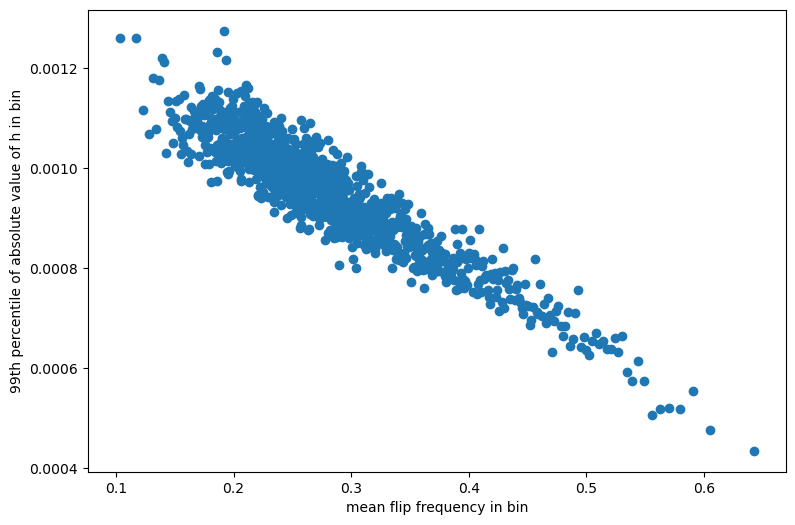

In [24]:
binned_abs_h_flip_frequency_correlation = isingmodel.get_pairwise_correlation( mat1=h_quantile.flatten(), mat2=frequency_means.flatten() )
print(f'for {num_bins} bins of size {bin_size}, correlation between mean absolute value of h and 99th percentile of flip_frequency in each bin is {binned_abs_h_flip_frequency_correlation:.3g}')
make_scatter(  xname=f'mean flip frequency in bin', xvalues=frequency_means, yname='99th percentile of absolute value of h in bin', yvalues=h_quantile)

correlation between flip frequency and mean of absolute value of J is 0.272


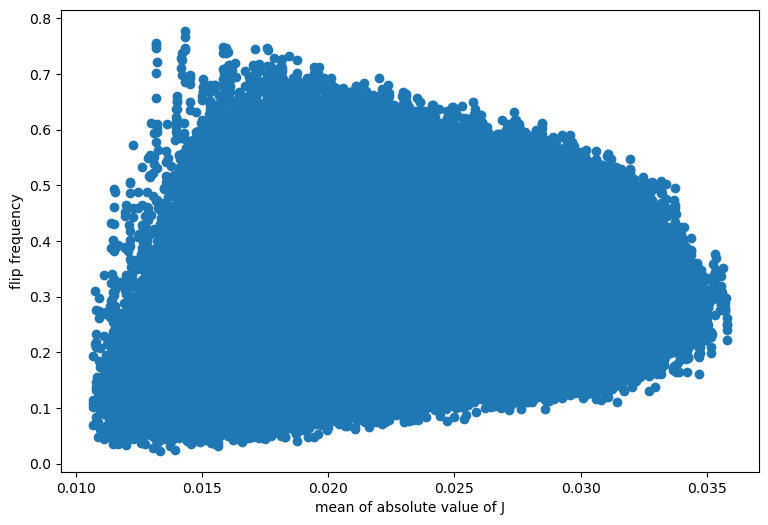

In [242]:
flip_frequency_mean_abs_J_correlation = isingmodel.get_pairwise_correlation( mat1=flip_frequency.flatten(), mat2=mean_abs_J.flatten() )
print(f'correlation between flip frequency and mean of absolute value of J is {flip_frequency_mean_abs_J_correlation:.3g}')
make_scatter(  xname=f'mean of absolute value of J', xvalues=mean_abs_J, yname='flip frequency', yvalues=flip_frequency)

In [9]:
target_mean_state_product_file = os.path.join(file_dir, 'target_state_product_means_group_training_and_individual_all_signed_params_rectangular_coords_times_beta.pt')
target_mean_state_product = torch.load(target_mean_state_product_file)
print( target_mean_state_product.size() )
models_per_subject, num_subjects, num_pairs = target_mean_state_product.size()
target_mean_state_product_square = isingmodel.triu_to_square_pairs( triu_pairs=target_mean_state_product.flatten(start_dim=0, end_dim=1), diag_fill=1.0 ).unflatten( dim=0, sizes=(models_per_subject, num_subjects) )
print( target_mean_state_product_square.size() )
mean_abs_target_mean_state_product = target_mean_state_product_square.abs().mean(dim=-1, keepdim=False)
print( mean_abs_target_mean_state_product.size() )

torch.Size([5, 669, 64620])
torch.Size([5, 669, 360, 360])
torch.Size([5, 669, 360])


correlation between flip frequency and mean of absolute value of FC between node and other nodes is -0.495


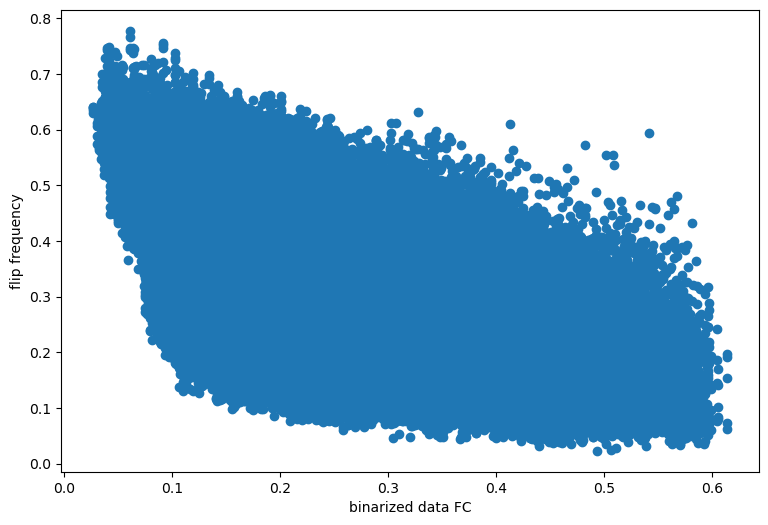

In [12]:
flip_frequency_mean_abs_fc_correlation = isingmodel.get_pairwise_correlation( mat1=flip_frequency.flatten(), mat2=mean_abs_target_mean_state_product.flatten() )
print(f'correlation between flip frequency and mean of absolute value of FC between node and other nodes is {flip_frequency_mean_abs_fc_correlation:.3g}')
make_scatter(  xname=f'binarized data FC', xvalues=mean_abs_target_mean_state_product, yname='flip frequency', yvalues=flip_frequency)

In [17]:
flip_rate_data_ts_file = os.path.join(file_dir, 'flip_rate_binary_data_ts_all.pt')
flip_rate_data_ts = torch.load(flip_rate_data_ts_file)
print( flip_rate_data_ts.size() )
flip_rate_data_ts = flip_rate_data_ts[1:670,:].unsqueeze(dim=0).repeat( (models_per_subject, 1, 1) )
print( flip_rate_data_ts.size() )

torch.Size([837, 360])
torch.Size([5, 669, 360])


correlation between flip frequencies of binarized fMRI time series and of fitted Ising model 0.143


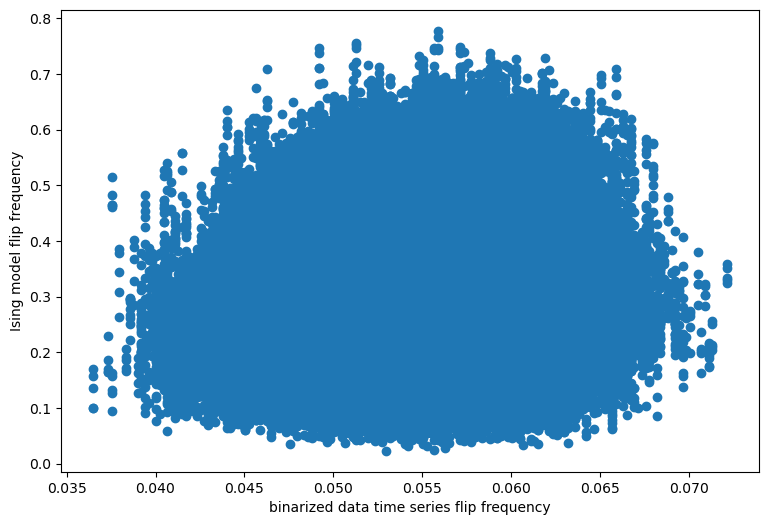

In [18]:
flip_frequency_flip_frequency_correlation = isingmodel.get_pairwise_correlation( mat1=flip_frequency.flatten(), mat2=flip_rate_data_ts.flatten() )
print(f'correlation between flip frequencies of binarized fMRI time series and of fitted Ising model {flip_frequency_flip_frequency_correlation:.3g}')
make_scatter(  xname=f'binarized data time series flip frequency', xvalues=flip_rate_data_ts, yname='Ising model flip frequency', yvalues=flip_frequency)

In [18]:
test_s = torch.tensor( [1, 2, 3, 4, 5], dtype=float_type, device=device )
print( 's', test_s)
test_J = torch.tensor( [[1, 10, 100, 1000, 10000],[2, 20, 200, 2000, 20000],[3, 30, 300, 3000, 30000],[4, 40, 400, 4000, 40000],[5, 50, 500, 5000, 50000]], dtype=float_type, device=device )
print( 'J', test_J)
test_Js = torch.matmul(test_J, test_s)
print( 'Js', test_Js )
test_sJ = torch.matmul(test_s, test_J)
print( 'sJ', test_sJ )
test_sJs = torch.matmul(test_s, torch.matmul(test_J, test_s) )
print( 'sJs', test_sJs )

s tensor([1., 2., 3., 4., 5.], device='cuda:0')
J tensor([[1.0000e+00, 1.0000e+01, 1.0000e+02, 1.0000e+03, 1.0000e+04],
        [2.0000e+00, 2.0000e+01, 2.0000e+02, 2.0000e+03, 2.0000e+04],
        [3.0000e+00, 3.0000e+01, 3.0000e+02, 3.0000e+03, 3.0000e+04],
        [4.0000e+00, 4.0000e+01, 4.0000e+02, 4.0000e+03, 4.0000e+04],
        [5.0000e+00, 5.0000e+01, 5.0000e+02, 5.0000e+03, 5.0000e+04]],
       device='cuda:0')
Js tensor([ 54321., 108642., 162963., 217284., 271605.], device='cuda:0')
sJ tensor([5.5000e+01, 5.5000e+02, 5.5000e+03, 5.5000e+04, 5.5000e+05],
       device='cuda:0')
sJs tensor(2987655., device='cuda:0')


In [20]:
test_Jis_1 = torch.dot(test_J[1,:], test_s)
print(test_Jis_1)
test_Jis_2 = torch.inner(test_J[1,:], test_s)
print(test_Jis_2)

tensor(108642., device='cuda:0')
tensor(108642., device='cuda:0')


In [22]:
test_Jis_rep = torch.inner( test_J[1,:].unsqueeze(dim=0).repeat((10,1)), test_s.unsqueeze(dim=0).repeat((10,1)) )
print(test_Jis_rep)

tensor([[108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 108642., 108642., 108642., 108642., 108642., 108642., 108642.,
         108642., 108642.],
        [108642., 1

In [9]:
stacked_size = (1000, 669, 360)
stacked_vec_1 = torch.randn( size=stacked_size, dtype=float_type, device=device )
stacked_vec_2 = torch.randn( size=stacked_size, dtype=float_type, device=device )

In [10]:
start_time = time.time()
for _ in range(10000):
    stacked_vec_1 = torch.randn( size=stacked_size, dtype=float_type, device=device )
    stacked_vec_2 = torch.randn( size=stacked_size, dtype=float_type, device=device )
    stacked_product = torch.sum( stacked_vec_1 * stacked_vec_2, dim=-1 )
print( stacked_product.size() )
print( f'time {time.time() - start_time}' )

torch.Size([1000, 669])
time 135.90697646141052


In [11]:
start_time = time.time()
for _ in range(10000):
    stacked_vec_1 = torch.randn( size=stacked_size, dtype=float_type, device=device )
    stacked_vec_2 = torch.randn( size=stacked_size, dtype=float_type, device=device )
    stacked_product = torch.matmul( stacked_vec_1.unsqueeze(dim=-2), stacked_vec_2.unsqueeze(dim=-1) )
print( stacked_product.size() )
print( f'time {time.time() - start_time}' )

torch.Size([1000, 669, 1, 1])
time 143.0099835395813


In [10]:
start_time = time.time()
stacked_product = torch.inner( stacked_vec_1, stacked_vec_2 )
print( stacked_product.size() )
print( f'time {time.time() - start_time}' )

OutOfMemoryError: CUDA out of memory. Tried to allocate 1667.29 GiB (GPU 0; 8.00 GiB total capacity; 1.79 GiB already allocated; 5.20 GiB free; 1.80 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
test_binary = torch.tensor([[[1,1,1],[1,0,1],[1,1,1]],[[0,1,1],[1,1,0],[1,1,1]],[[1,0,1],[1,1,1],[0,1,1]]], dtype=float_type, device=device)
print( test_binary, test_binary.size() )
is_one = test_binary == 1
num_ones = torch.count_nonzero(is_one)
print( is_one.size(), num_ones )
test_binary[is_one] = torch.arange(num_ones, dtype=float_type, device=device)
print(test_binary)
print( torch.arange(num_ones, dtype=float_type, device=device) % 2 )

tensor([[[1., 1., 1.],
         [1., 0., 1.],
         [1., 1., 1.]],

        [[0., 1., 1.],
         [1., 1., 0.],
         [1., 1., 1.]],

        [[1., 0., 1.],
         [1., 1., 1.],
         [0., 1., 1.]]], device='cuda:0') torch.Size([3, 3, 3])
torch.Size([3, 3, 3]) tensor(22, device='cuda:0')
tensor([[[ 0.,  1.,  2.],
         [ 3.,  0.,  4.],
         [ 5.,  6.,  7.]],

        [[ 0.,  8.,  9.],
         [10., 11.,  0.],
         [12., 13., 14.]],

        [[15.,  0., 16.],
         [17., 18., 19.],
         [ 0., 20., 21.]]], device='cuda:0')
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1.], device='cuda:0')


In [12]:
fim_diag_file = os.path.join(file_dir, 'fim_diag_sim_length_120000_group_training_and_individual_all_fold_1_betas_5_steps_1200_lr_0.01_h_yes.pt')
fim_diag = torch.load(fim_diag_file)
print( fim_diag.size() )

tensor([[0.9990, 0.9995, 0.9993,  ..., 0.9491, 0.9550, 0.8038],
        [0.9979, 0.9973, 0.9979,  ..., 0.9865, 0.9893, 0.7812],
        [0.9994, 0.9990, 0.9989,  ..., 0.9729, 0.9909, 0.9049],
        ...,
        [0.9988, 0.9992, 0.9995,  ..., 0.9836, 0.9478, 0.9485],
        [0.9999, 0.9999, 0.9997,  ..., 0.9987, 0.9954, 0.9296],
        [0.9981, 0.9994, 0.9992,  ..., 0.9112, 0.9480, 0.8122]],
       device='cuda:0')


In [13]:
print( fim_diag.size() )
same_node_and_subject_h_var = h.var(dim=0)

torch.Size([4190, 64980])


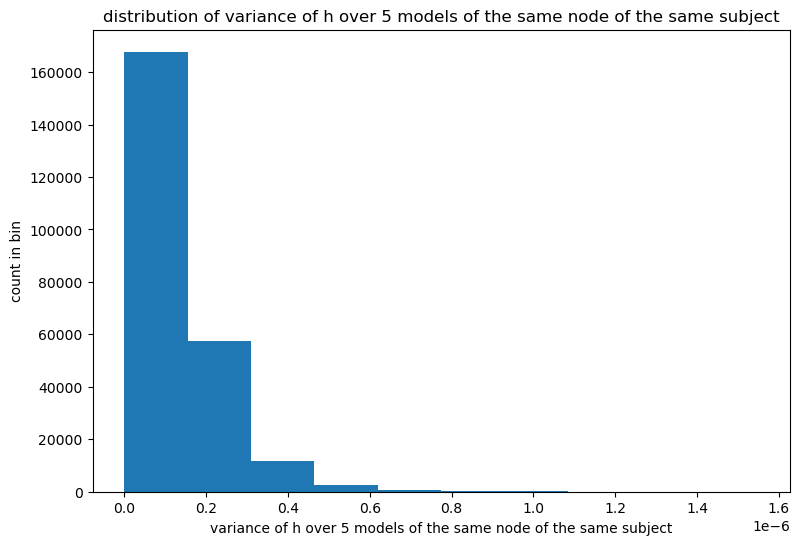

The distribution of variance of h over 5 models of the same node of the same subject values has median 1.04e-07 with 95% CI [1.37e-08, 4.14e-07] and range [2e-10, 1.55e-06].


In [17]:
name = 'variance of h over 5 models of the same node of the same subject'
values = same_node_and_subject_h_var
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [15]:
node_variance_file = os.path.join(file_dir, 'node_variance_group_training_and_individual_all.pt')
node_variance = torch.load(node_variance_file)
print( node_variance.size() )

torch.Size([5, 669, 360])


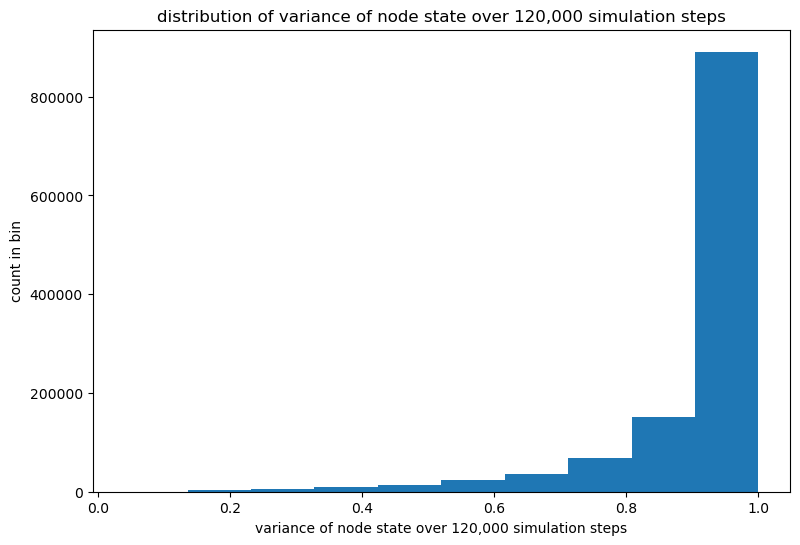

The distribution of variance of node state over 120,000 simulation steps values has median 0.971 with 95% CI [0.503, 1] and range [0.0396, 1].


In [18]:
name = 'variance of node state over 120,000 simulation steps'
values = node_variance
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

correlation between h and observed node variance of fitted Ising model 0.00236


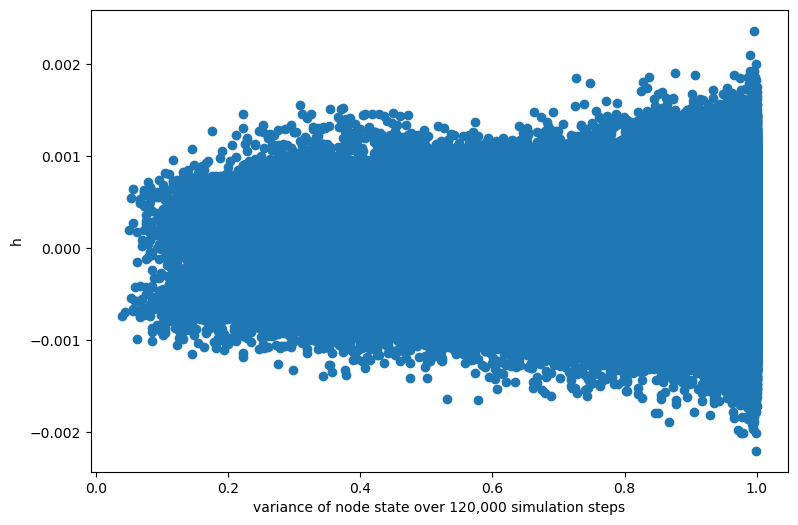

In [19]:
h_node_var_correlation = isingmodel.get_pairwise_correlation( mat1=node_variance.flatten(), mat2=h.flatten() )
print(f'correlation between h and observed node variance of fitted Ising model {h_node_var_correlation:.3g}')
make_scatter(  xname=f'variance of node state over 120,000 simulation steps', xvalues=node_variance, yname='h', yvalues=h)

In [20]:
pooled_node_variance = 1 - (1 - node_variance).sqrt().mean(dim=0).square()

correlation between variance of h and variance of node state over model instances of fitted Ising model 0.0988


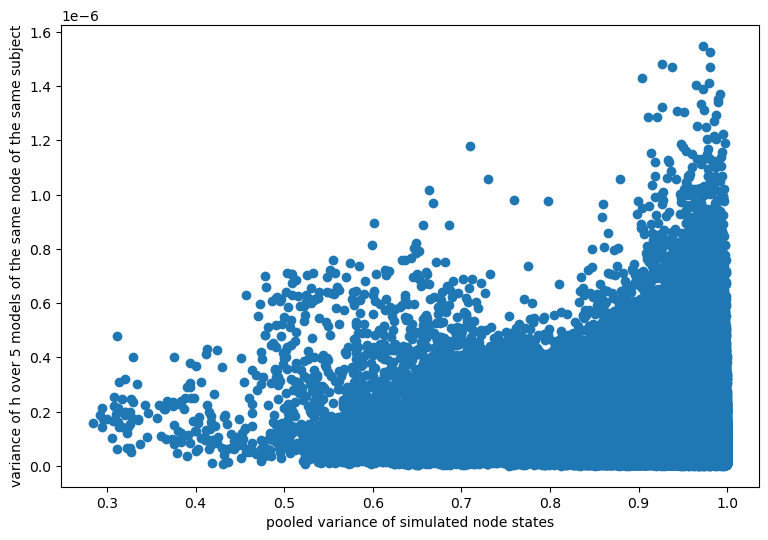

In [23]:
h_var_node_var_correlation = isingmodel.get_pairwise_correlation( mat1=pooled_node_variance.flatten(), mat2=same_node_and_subject_h_var.flatten() )
print(f'correlation between variance of h and variance of node state over model instances of fitted Ising model {h_var_node_var_correlation:.3g}')
make_scatter(  xname=f'pooled variance of simulated node states', xvalues=pooled_node_variance, yname='variance of h over 5 models of the same node of the same subject', yvalues=same_node_and_subject_h_var)

In [24]:
abs_h = h.abs()

In [34]:
abs_h_node_var_correlation = isingmodel.get_pairwise_correlation( mat1=node_variance.flatten(), mat2=abs_h.flatten() )
print(f'correlation between absolute value of h and observed node variance of fitted Ising model {abs_h_node_var_correlation:.3g}')
make_scatter(  xname=f'variance of node state over 120,000 simulation steps', xvalues=node_variance, yname='|h|', yvalues=abs_h)

correlation between absolute value of h and observed node variance of fitted Ising model -0.0168


In [37]:
# bin_size = 5400
# num_bins = abs_h.numel()//bin_size
num_bins = 36
bin_size = abs_h.numel()//num_bins
node_var_means, h_quantile = bin_frequency_mean_h_quantile(frequency=node_variance, h=abs_h, bin_size=bin_size, q=0.99)
print( node_var_means.size() )
print( h_quantile.size() )

torch.Size([36])
torch.Size([36])


In [38]:
binned_abs_h_node_var_correlation = isingmodel.get_pairwise_correlation( mat1=h_quantile.flatten(), mat2=node_var_means.flatten() )
print(f'for {num_bins} bins of size {bin_size}, correlation between mean of variance of node state and 99th percentile of absolute value of h in each bin is {binned_abs_h_node_var_correlation:.3g}')
make_scatter(  xname=f'mean node variance in bin', xvalues=node_var_means, yname='99th percentile of absolute value of h in bin', yvalues=h_quantile)

for 36 bins of size 33450, correlation between mean of variance of node state and 99th percentile of absolute value of h in each bin is -0.576


In [176]:
mlp_true_correlations_long = torch.load( os.path.join(file_dir, 'true_correlations_group_training_and_individual_all_signed_params_times_beta_epochs_10000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( mlp_true_correlations_long.size(), torch.std_mean(mlp_true_correlations_long, dim=0) )

torch.Size([100, 2]) (tensor([0.0011, 0.0022], device='cuda:0'), tensor([0.0008, 0.4079], device='cuda:0'))


In [177]:
mlp_true_correlations = torch.load( os.path.join(file_dir, 'true_correlations_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( mlp_true_correlations.size(), torch.std_mean(mlp_true_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0165], device='cuda:0'), tensor([1.7520e-04, 3.7772e-01], device='cuda:0'))


In [187]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = '1000 epochs'
values1 = mlp_true_correlations[:,param_index]
label2 = '10,000 epochs'
values2 = mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

MannwhitneyuResult(statistic=3765.0, pvalue=0.002558263037242641)
The distribution of correlation between h predicted from structure and fMRI-fitted h with 1000 epochs values has median 0.000301 with 95% CI [-0.00202, 0.00231] and range [-0.0023, 0.00259].
The distribution of correlation between h predicted from structure and fMRI-fitted h with 10,000 epochs values has median 0.000468 with 95% CI [-0.000639, 0.00343] and range [-0.000922, 0.00569].


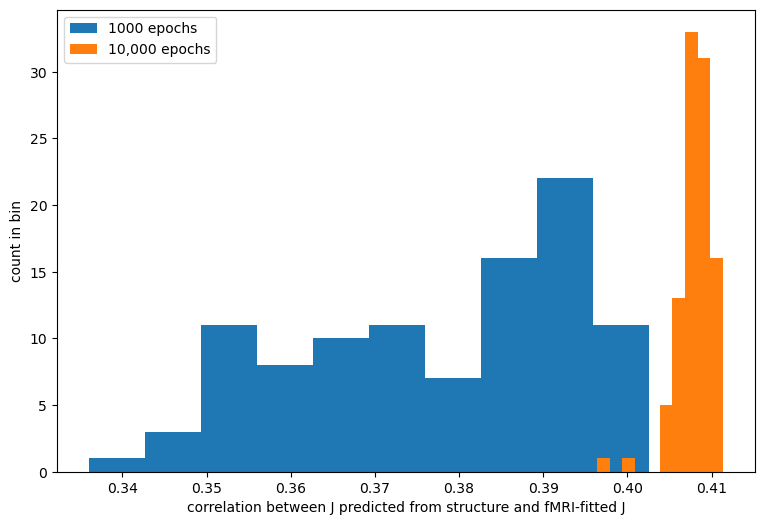

MannwhitneyuResult(statistic=16.0, pvalue=4.140464634938016e-34)
The distribution of correlation between J predicted from structure and fMRI-fitted J with 1000 epochs values has median 0.382 with 95% CI [0.348, 0.401] and range [0.336, 0.403].
The distribution of correlation between J predicted from structure and fMRI-fitted J with 10,000 epochs values has median 0.408 with 95% CI [0.404, 0.411] and range [0.396, 0.411].


In [188]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = '1000 epochs'
values1 = mlp_true_correlations[:,param_index]
label2 = '10,000 epochs'
values2 = mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

In [178]:
mlp_perm_subjects_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_subjects_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( mlp_perm_subjects_correlations.size(), torch.std_mean(mlp_perm_subjects_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0159], device='cuda:0'), tensor([3.6989e-05, 3.7331e-01], device='cuda:0'))


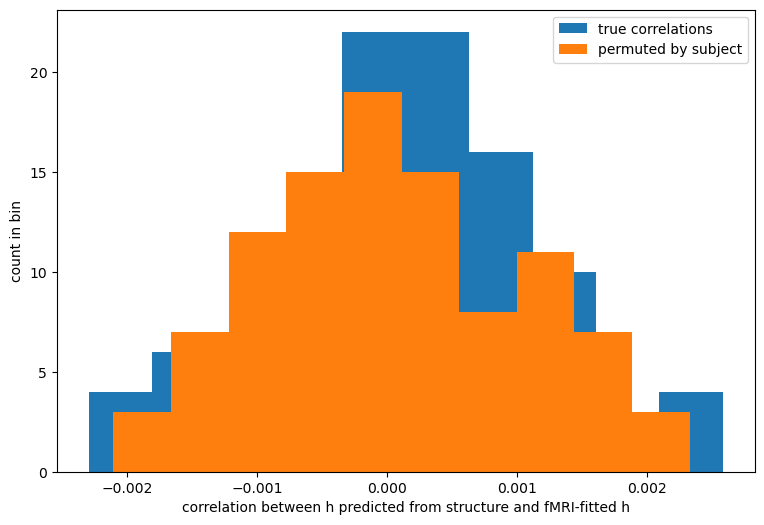

MannwhitneyuResult(statistic=5570.0, pvalue=0.1640708381003526)
The distribution of correlation between h predicted from structure and fMRI-fitted h true correlations values has median 0.000301 with 95% CI [-0.00202, 0.00231] and range [-0.0023, 0.00259].
The distribution of correlation between h predicted from structure and fMRI-fitted h permuted by subject values has median -5.68e-05 with 95% CI [-0.00168, 0.00183] and range [-0.00211, 0.00233].


In [189]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by subject'
values2 = mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

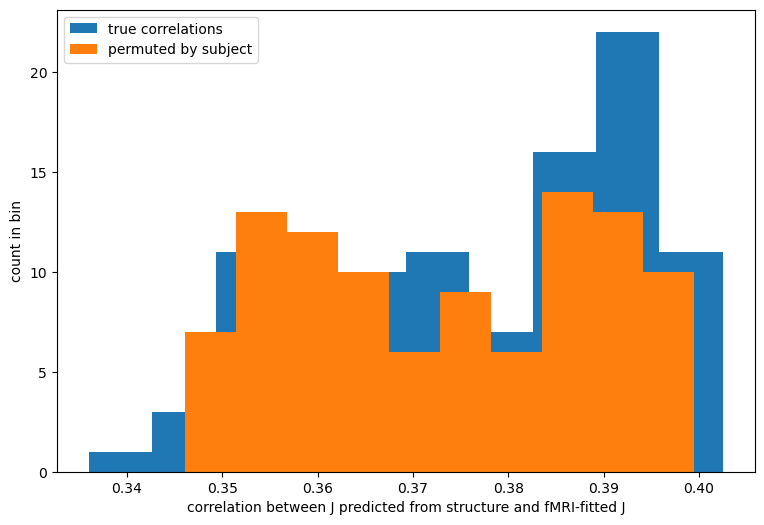

MannwhitneyuResult(statistic=5813.0, pvalue=0.047116277950033134)
The distribution of correlation between J predicted from structure and fMRI-fitted J true correlations values has median 0.382 with 95% CI [0.348, 0.401] and range [0.336, 0.403].
The distribution of correlation between J predicted from structure and fMRI-fitted J permuted by subject values has median 0.374 with 95% CI [0.348, 0.397] and range [0.346, 0.4].


In [190]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by subject'
values2 = mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

In [191]:
mlp_perm_nodes_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_nodes_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( mlp_perm_nodes_correlations.size(), torch.std_mean(mlp_perm_nodes_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0031], device='cuda:0'), tensor([-7.8222e-05,  4.6300e-03], device='cuda:0'))


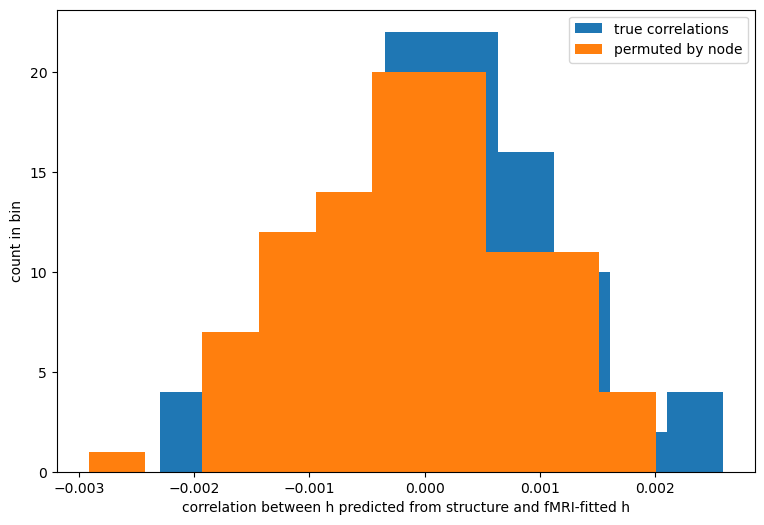

MannwhitneyuResult(statistic=5799.0, pvalue=0.05105157086470267)
The distribution of correlation between h predicted from structure and fMRI-fitted h true correlations values has median 0.000301 with 95% CI [-0.00202, 0.00231] and range [-0.0023, 0.00259].
The distribution of correlation between h predicted from structure and fMRI-fitted h permuted by node values has median -3.99e-05 with 95% CI [-0.00168, 0.00161] and range [-0.00291, 0.00201].


In [192]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by node'
values2 = mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

In [193]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by node'
values2 = mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

MannwhitneyuResult(statistic=10000.0, pvalue=2.562143669163401e-34)
The distribution of correlation between J predicted from structure and fMRI-fitted J true correlations values has median 0.382 with 95% CI [0.348, 0.401] and range [0.336, 0.403].
The distribution of correlation between J predicted from structure and fMRI-fitted J permuted by node values has median 0.0039 with 95% CI [0.000689, 0.0104] and range [-0.00121, 0.0165].


In [194]:
mlp_perm_both_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_both_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( mlp_perm_both_correlations.size(), torch.std_mean(mlp_perm_both_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0008, 0.0029], device='cuda:0'), tensor([-4.5156e-05,  4.2991e-03], device='cuda:0'))


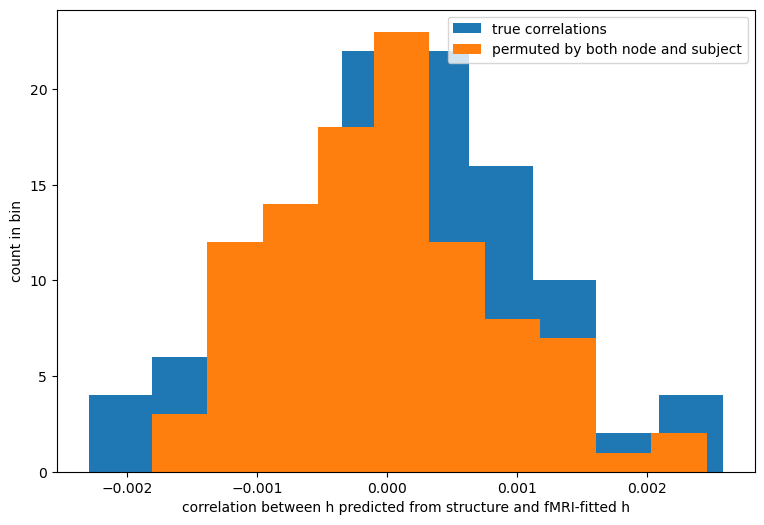

MannwhitneyuResult(statistic=5891.0, pvalue=0.029567390812497398)
The distribution of correlation between h predicted from structure and fMRI-fitted h true correlations values has median 0.000301 with 95% CI [-0.00202, 0.00231] and range [-0.0023, 0.00259].
The distribution of correlation between h predicted from structure and fMRI-fitted h permuted by both node and subject values has median -5.1e-05 with 95% CI [-0.00141, 0.0017] and range [-0.00181, 0.00246].


In [195]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by both node and subject'
values2 = mlp_perm_both_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

In [196]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = mlp_true_correlations[:,param_index]
label2 = 'permuted by both node and subject'
values2 = mlp_perm_both_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} {label1}', values=values1)
print_stats(name=f'{value_name} {label2}', values=values2)

MannwhitneyuResult(statistic=10000.0, pvalue=2.562143669163401e-34)
The distribution of correlation between J predicted from structure and fMRI-fitted J true correlations values has median 0.382 with 95% CI [0.348, 0.401] and range [0.336, 0.403].
The distribution of correlation between J predicted from structure and fMRI-fitted J permuted by both node and subject values has median 0.00381 with 95% CI [-0.000562, 0.00935] and range [-0.00215, 0.0153].


In [197]:
diff_mlp_true_correlations_long = torch.load( os.path.join(file_dir, 'true_correlations_diff_vs_diff_group_training_and_individual_all_signed_params_times_beta_epochs_10000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( diff_mlp_true_correlations_long.size(), torch.std_mean(diff_mlp_true_correlations_long, dim=0) )

torch.Size([100, 2]) (tensor([0.0021, 0.0013], device='cuda:0'), tensor([-0.0025,  0.0301], device='cuda:0'))


In [198]:
diff_mlp_true_correlations = torch.load( os.path.join(file_dir, 'true_correlations_diff_vs_diff_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( diff_mlp_true_correlations.size(), torch.std_mean(diff_mlp_true_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0043], device='cuda:0'), tensor([-6.9818e-05,  2.1936e-02], device='cuda:0'))


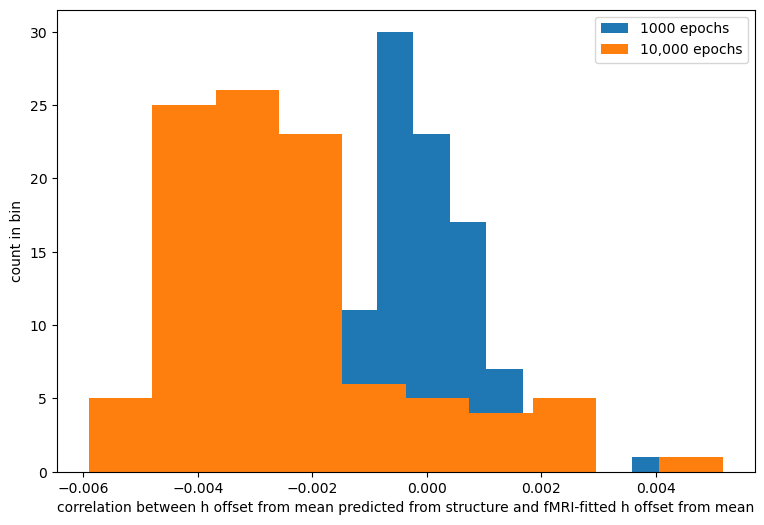

MannwhitneyuResult(statistic=8629.0, pvalue=7.593177639897255e-19)
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with 1000 epochs values has median -0.000152 with 95% CI [-0.00183, 0.00186] and range [-0.00215, 0.00422].
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with 10,000 epochs values has median -0.00289 with 95% CI [-0.00525, 0.00246] and range [-0.00591, 0.00517].


In [199]:
param_name = 'h offset from mean'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = '1000 epochs'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = '10,000 epochs'
values2 = diff_mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

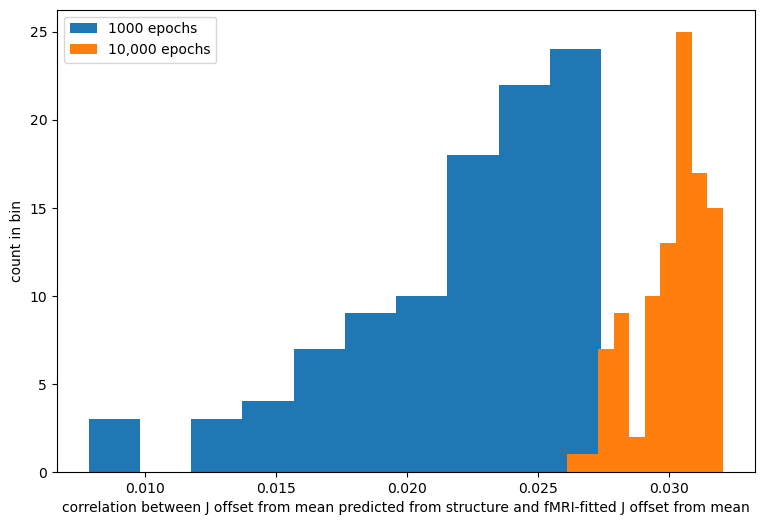

MannwhitneyuResult(statistic=16.0, pvalue=4.140464634938016e-34)
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with 1000 epochs values has median 0.0232 with 95% CI [0.0112, 0.0266] and range [0.00783, 0.0274].
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with 10,000 epochs values has median 0.0304 with 95% CI [0.0274, 0.0318] and range [0.0261, 0.0321].


In [200]:
param_name = 'J offset from mean'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = '1000 epochs'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = '10,000 epochs'
values2 = diff_mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

In [201]:
diff_mlp_perm_subjects_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_subjects_diff_vs_diff_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( diff_mlp_perm_subjects_correlations.size(), torch.std_mean(diff_mlp_perm_subjects_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0009, 0.0002], device='cuda:0'), tensor([0.0001, 0.0001], device='cuda:0'))


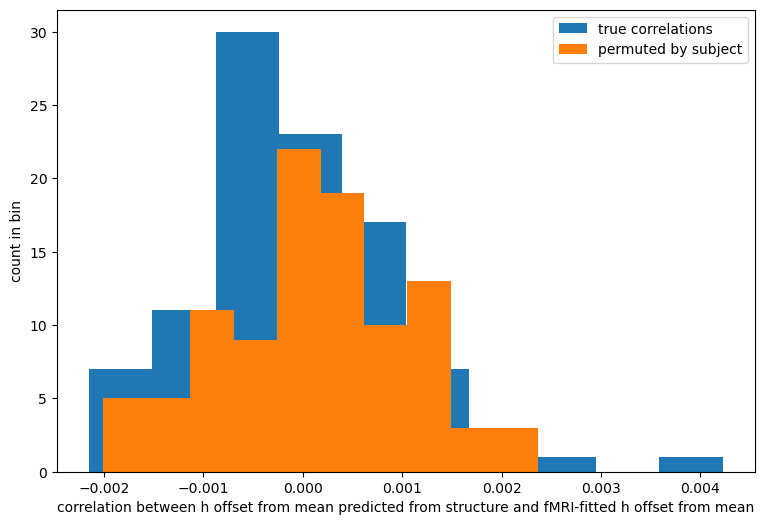

MannwhitneyuResult(statistic=4277.0, pvalue=0.07750521791497839)
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with true correlations values has median -0.000152 with 95% CI [-0.00183, 0.00186] and range [-0.00215, 0.00422].
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with permuted by subject values has median 0.000144 with 95% CI [-0.00164, 0.00184] and range [-0.00201, 0.00236].


In [202]:
param_name = 'h offset from mean'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by subject'
values2 = diff_mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

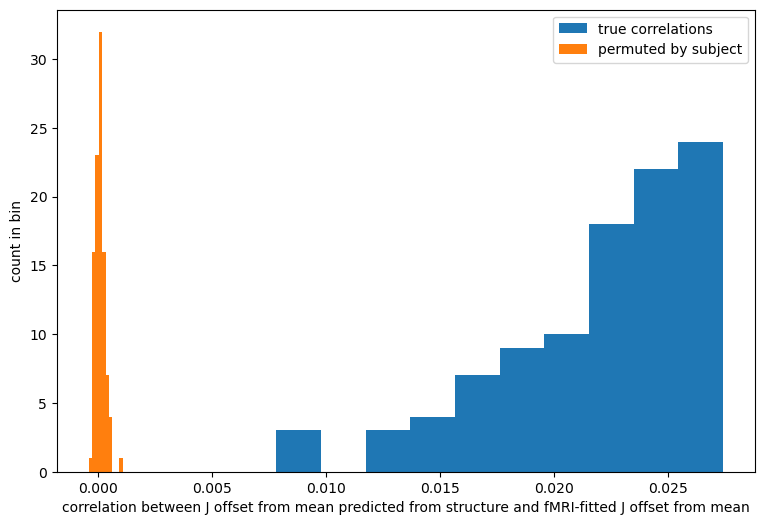

MannwhitneyuResult(statistic=10000.0, pvalue=2.562143669163401e-34)
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with true correlations values has median 0.0232 with 95% CI [0.0112, 0.0266] and range [0.00783, 0.0274].
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with permuted by subject values has median 9.05e-05 with 95% CI [-0.000227, 0.000567] and range [-0.000393, 0.00109].


In [203]:
param_name = 'J offset from mean'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by subject'
values2 = diff_mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

In [204]:
diff_mlp_perm_nodes_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_nodes_diff_vs_diff_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( diff_mlp_perm_nodes_correlations.size(), torch.std_mean(diff_mlp_perm_nodes_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0002], device='cuda:0'), tensor([0.0002, 0.0001], device='cuda:0'))


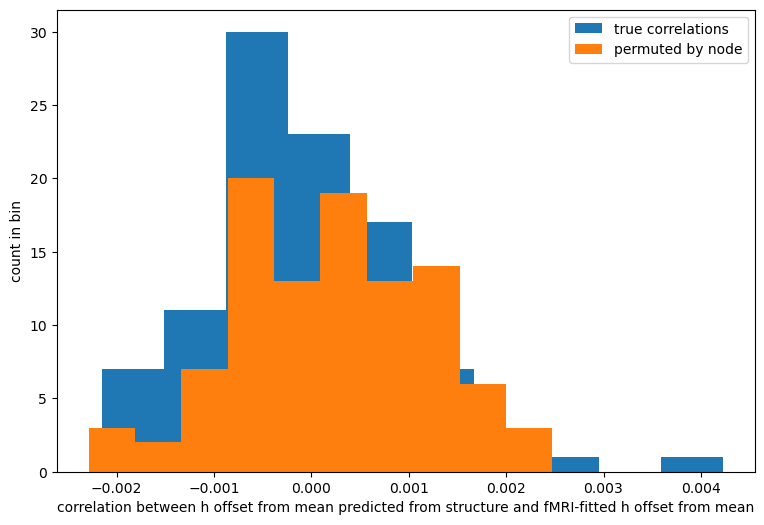

MannwhitneyuResult(statistic=4039.0, pvalue=0.018931603518644882)
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with true correlations values has median -0.000152 with 95% CI [-0.00183, 0.00186] and range [-0.00215, 0.00422].
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with permuted by node values has median 0.000277 with 95% CI [-0.00182, 0.00203] and range [-0.00229, 0.00247].


In [205]:
param_name = 'h offset from mean'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by node'
values2 = diff_mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

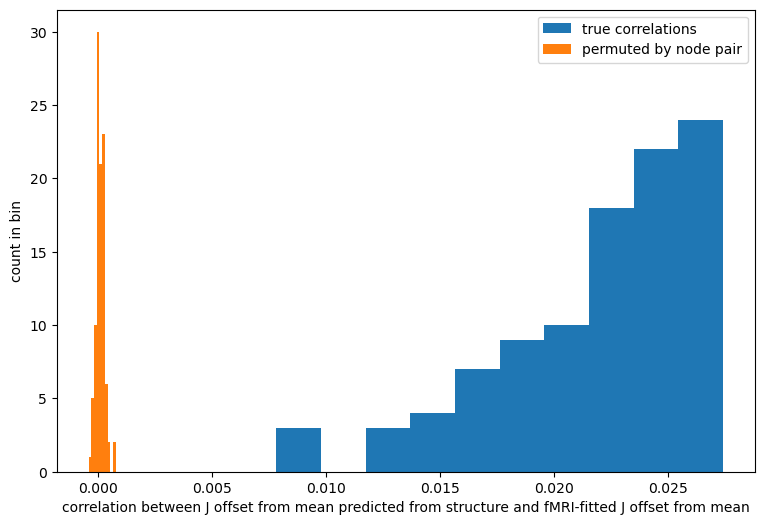

MannwhitneyuResult(statistic=10000.0, pvalue=2.562143669163401e-34)
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with true correlations values has median 0.0232 with 95% CI [0.0112, 0.0266] and range [0.00783, 0.0274].
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with permuted by node pair values has median 7.8e-05 with 95% CI [-0.000215, 0.000482] and range [-0.000406, 0.000774].


In [206]:
param_name = 'J offset from mean'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by node pair'
values2 = diff_mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

In [207]:
diff_mlp_perm_both_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_both_diff_vs_diff_group_training_and_individual_all_signed_params_times_beta_epochs_1000_lr_0.001_depth_1_width_13_permutations_100.pt') )
print( diff_mlp_perm_both_correlations.size(), torch.std_mean(diff_mlp_perm_both_correlations, dim=0) )

torch.Size([100, 2]) (tensor([0.0010, 0.0002], device='cuda:0'), tensor([4.0348e-05, 1.0011e-04], device='cuda:0'))


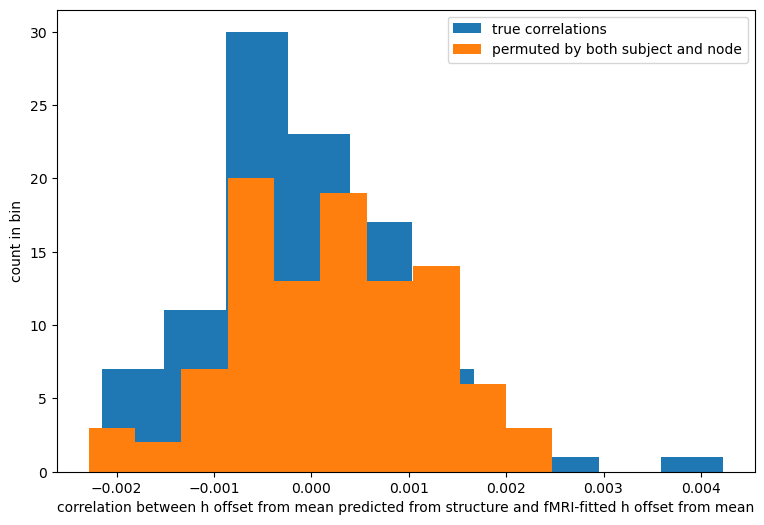

MannwhitneyuResult(statistic=4039.0, pvalue=0.018931603518644882)
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with true correlations values has median -0.000152 with 95% CI [-0.00183, 0.00186] and range [-0.00215, 0.00422].
The distribution of correlation between h offset from mean predicted from structure and fMRI-fitted h offset from mean with permuted by both subject and node values has median 0.000277 with 95% CI [-0.00182, 0.00203] and range [-0.00229, 0.00247].


In [208]:
param_name = 'h offset from mean'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by both subject and node'
values2 = diff_mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

In [209]:
param_name = 'J offset from mean'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = diff_mlp_true_correlations[:,param_index]
label2 = 'permuted by both subject and node pair'
values2 = diff_mlp_perm_nodes_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

MannwhitneyuResult(statistic=10000.0, pvalue=2.562143669163401e-34)
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with true correlations values has median 0.0232 with 95% CI [0.0112, 0.0266] and range [0.00783, 0.0274].
The distribution of correlation between J offset from mean predicted from structure and fMRI-fitted J offset from mean with permuted by both subject and node pair values has median 7.8e-05 with 95% CI [-0.000215, 0.000482] and range [-0.000406, 0.000774].


In [210]:
deep_mlp_true_correlations = torch.load( os.path.join(file_dir, 'true_correlations_group_training_and_individual_all_signed_params_times_beta_epochs_10000_lr_0.001_depth_13_width_13_permutations_10.pt') )
print( deep_mlp_true_correlations.size(), torch.std_mean(deep_mlp_true_correlations, dim=0) )

torch.Size([10, 2]) (tensor([0.0013, 0.0026], device='cuda:0'), tensor([4.1490e-04, 4.2916e-01], device='cuda:0'))


In [212]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = '13 hidden layers'
values1 = deep_mlp_true_correlations[:,param_index]
label2 = '1 hidden layer'
values2 = mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

MannwhitneyuResult(statistic=377.0, pvalue=0.20277175958078442)
The distribution of correlation between h predicted from structure and fMRI-fitted h with 13 hidden layers values has median 0.000204 with 95% CI [-0.000998, 0.003] and range [-0.00108, 0.00351].
The distribution of correlation between h predicted from structure and fMRI-fitted h with 1 hidden layer values has median 0.000468 with 95% CI [-0.000639, 0.00343] and range [-0.000922, 0.00569].


In [218]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label2 = '13 hidden layers'
values2 = deep_mlp_true_correlations[:,param_index]
label1 = '1 hidden layer'
values1 = mlp_true_correlations_long[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

MannwhitneyuResult(statistic=0.0, pvalue=2.0631739856825891e-07)
The distribution of correlation between J predicted from structure and fMRI-fitted J with 1 hidden layer values has median 0.408 with 95% CI [0.404, 0.411] and range [0.396, 0.411].
The distribution of correlation between J predicted from structure and fMRI-fitted J with 13 hidden layers values has median 0.429 with 95% CI [0.426, 0.434] and range [0.426, 0.434].


In [211]:
deep_mlp_perm_subjects_correlations = torch.load( os.path.join(file_dir, 'perm_correlations_subjects_group_training_and_individual_all_signed_params_times_beta_epochs_10000_lr_0.001_depth_13_width_13_permutations_10.pt') )
print( deep_mlp_perm_subjects_correlations.size(), torch.std_mean(deep_mlp_perm_subjects_correlations, dim=0) )

torch.Size([10, 2]) (tensor([0.0016, 0.0030], device='cuda:0'), tensor([0.0012, 0.4239], device='cuda:0'))


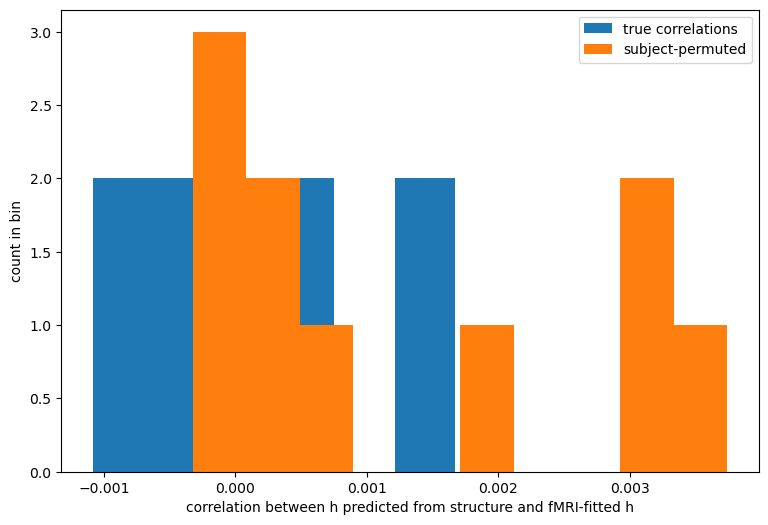

MannwhitneyuResult(statistic=33.0, pvalue=0.21229383619233155)
The distribution of correlation between h predicted from structure and fMRI-fitted h with true correlations values has median 0.000204 with 95% CI [-0.000998, 0.003] and range [-0.00108, 0.00351].
The distribution of correlation between h predicted from structure and fMRI-fitted h with subject-permuted values has median 0.000468 with 95% CI [-0.000305, 0.00359] and range [-0.000323, 0.00374].


In [214]:
param_name = 'h'
param_index = 0
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = deep_mlp_true_correlations[:,param_index]
label2 = 'subject-permuted'
values2 = deep_mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)

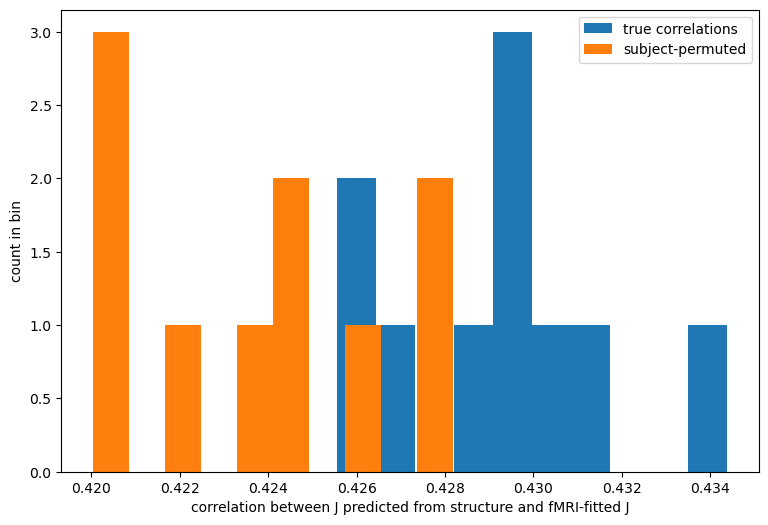

MannwhitneyuResult(statistic=93.0, pvalue=0.0013149446697132139)
The distribution of correlation between J predicted from structure and fMRI-fitted J with true correlations values has median 0.429 with 95% CI [0.426, 0.434] and range [0.426, 0.434].
The distribution of correlation between J predicted from structure and fMRI-fitted J with subject-permuted values has median 0.424 with 95% CI [0.42, 0.428] and range [0.42, 0.428].


In [215]:
param_name = 'J'
param_index = 1
value_name = f'correlation between {param_name} predicted from structure and fMRI-fitted {param_name}'
label1 = 'true correlations'
values1 = deep_mlp_true_correlations[:,param_index]
label2 = 'subject-permuted'
values2 = deep_mlp_perm_subjects_correlations[:,param_index]
make_histogram_pair(values1=values1, values2=values2, label1=label1, label2=label2, xlabel=value_name)
print_stats(name=f'{value_name} with {label1}', values=values1)
print_stats(name=f'{value_name} with {label2}', values=values2)